In [1]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Import


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px

import charset_normalizer
import fuzzywuzzy
from fuzzywuzzy import process
import os
import re
from dateutil import parser

import warnings

warnings.filterwarnings("ignore")
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# Character encoding


## Train set


In [3]:
train_df_name = []
train_encoding = []
train_path = []

dataset_folder = "dataset"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    train_path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        train_encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    train_df_name.append(file_name)
    print(f"{file_name}: {result}")


train_data_source = (tuple(train_df_name), tuple(train_encoding), tuple(train_path))
context = pd.read_csv(train_data_source[2][0], encoding=train_data_source[1][0])
mobile_plan_attr = pd.read_csv(
    train_data_source[2][1], encoding=train_data_source[1][1], delimiter=";"
)
mobile_plan_user = pd.read_csv(train_data_source[2][2], encoding=train_data_source[1][2])
user = pd.read_csv(train_data_source[2][3], encoding=train_data_source[1][3])


train_set = [context, mobile_plan_attr, mobile_plan_user, user]

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'English', 'confidence': 1.0}


## Test set


In [4]:
test_df_name = []
test_encoding = []
test_path = []

dataset_folder = "test"
for file in os.listdir(dataset_folder):
    file_path = os.path.join(dataset_folder, file)
    test_path.append(file_path)
    # look at the first ten thousand bytes to guess the character encoding
    with open(file_path, "rb") as rawdata:
        result = charset_normalizer.detect(rawdata.read())
        test_encoding.append(result["encoding"])
    # check what the character encoding might be
    file_name = os.path.splitext(file)[0]
    test_df_name.append(file_name)
    print(f"{file_name}: {result}")

test_data_source = (tuple(test_df_name), tuple(test_encoding), tuple(test_path))
context_test = pd.read_csv(test_data_source[2][0], encoding=test_data_source[1][0])
mobile_plan_attr_test = pd.read_csv(
    test_data_source[2][1], encoding=test_data_source[1][1], delimiter=";"
)
mobile_plan_user_test = pd.read_csv(test_data_source[2][2], encoding=test_data_source[1][2])
user_test = pd.read_csv(test_data_source[2][3], encoding=test_data_source[1][3])


test_set = [context_test, mobile_plan_attr_test, mobile_plan_user_test, user_test]

context: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_attr: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
mobile_plan_user: {'encoding': 'ascii', 'language': 'English', 'confidence': 1.0}
user: {'encoding': 'utf-8', 'language': 'Spanish', 'confidence': 1.0}


# Cleaning

## Missing values check


In [5]:
print('*'*10 + ' Train set ' + '*'*10)
for x in train_set:
  print('-----------------')
  print(x.isna().sum())
print('')

print('*'*10 + ' Test set ' + '*'*10)
for x in test_set:
  print('-----------------')
  print(x.isna().sum())

********** Train set **********
-----------------
id              0
purpose         0
go_with         0
weather         0
time            0
viettel_no_0    0
viettel_no_1    0
viettel_no_2    0
to_hanoi        0
to_other        0
score           0
direction       0
dtype: int64
-----------------
mobile_plan    0
description    0
price          0
duration       0
dtype: int64
-----------------
id                0
mobile_plan    2715
accept         2721
dtype: int64
-----------------
id                      0
name                    0
gender                  0
age                     0
education            4003
profession              0
income                  0
living_with             0
nation                  0
phone                   0
job                     0
fb_freq                 0
yt_freq                 0
insta_freq              0
use_less_than_2GB       0
use_2GB_to_4GB          0
dtype: int64

********** Test set **********
-----------------
id              0
purpose         

In [6]:
mobile_plan_user = mobile_plan_user.dropna(subset=['mobile_plan', 'accept'])

mobile_plan_user_test = mobile_plan_user_test.dropna(subset=['coupon_id', 'accept'])

## Duplicate


In [7]:
print(user['id'].duplicated().sum())

print(user_test['id'].duplicated().sum())

0
0


In [8]:
print(context['id'].duplicated().sum())

print(context_test['id'].duplicated().sum())

0
0


In [9]:
print(mobile_plan_user[mobile_plan_user.duplicated(subset=['id'])].sort_values('id').head())

print('')

print(mobile_plan_user_test[mobile_plan_user_test.duplicated(subset=['id'])].sort_values('id').head())

           id  mobile_plan  accept
18023  1000.0  SOCIALMEDIA     0.0
18022  1000.0     DATACALL     0.0
18021  1000.0   DATASILVER     0.0
18162  1001.0  SOCIALMEDIA     0.0
18163  1001.0     DATACALL     0.0

          id    coupon_id  accept
1155  1064.0   DATASILVER     0.0
1121  1331.0  SOCIALMEDIA     1.0
1120  1331.0  SOCIALMEDIA     1.0
1310  1625.0  SOCIALMEDIA     0.0
1332  1733.0   DATASILVER     0.0


## Context


In [10]:
context.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
3511,1830,Travel,Family,Rain?y,8 AM,1,0,0,0,1,0,0
150,8547,Travel,Fri e~nd(s),!%~Sunny,8 AM,1,0,0,0,1,0,0
11222,4632,Visit,~~? Alone,Sunny,15:00,1,1,0,1,0,0,1
8352,9902,Travel,Alone,Sunny,10AM,1,0,0,0,1,0,0
98,9034,Travel,F riend(s),?&%%Sunny,8:00,1,0,0,0,1,76,0


In [11]:
context_test.sample(5)

,id,purpose,go_with,weather,time,viettel_no_0,viettel_no_1,viettel_no_2,to_hanoi,to_other,score,direction
337,2725,Visit,&A %lone,&Sun?ny,17:00,1,1,0,1,0,0,1
225,3752,Travel,Friend(s),Sun?ny,1 PM,1,1,0,0,1,3,0
549,2775,Travel,Fr? ien?d(s),&%S!!nowy,12AM,1,0,0,0,1,9,0
963,12989,Travel,F~riend(s),Sunny,7PM,1,1,0,0,1,0,0
816,7188,Visit,Al!one,S%un~ny,5PM,1,1,1,0,1,0,0


### Go with and weather


In [12]:
for x in ["go_with", "weather"]:
    # Eliminate special characters and white spaces
    context[x] = context[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))
    context_test[x] = context_test[x].apply(lambda x: re.sub(r"[^a-zA-Z\s]", "", x))

    # Lowercase all words
    context[x] = context[x].str.lower()
    context_test[x] = context_test[x].str.lower()

    print(context[x].unique())
    print('')
    print(context_test[x].unique())

['alone' 'friends' 'fa mily' 'family' 'fami ly' 'a l one' 'fr iends'
 ' alone' 'a lone' '  alone' ' friends' 'f riends' 'f rie nds' 'frie nds'
 'frien ds' 'f amily' ' family' 'alo ne' 'friend s' 'al one' 'fri ends'
 ' a lone' ' fri ends' 'f riend s' 'alon e' 'frien  ds' ' fri e nds'
 'friends ' 'a  lone' 'fa  mily' 'al  one' '   alone' 'fri e nds'
 ' al one' 'fam ily' '  family' 'f rien ds' '  a lone' ' f amily'
 'frie   nds' 'fri en ds' 'f a mily' ' frie nds' 'f  amily' 'fr  iends'
 ' fa mily' 'famil y' ' fr iends' 'fr ie nds' 'fr ien ds' ' f  amily'
 'fam  ily' ' frien ds' 'frie nd s' 'frie n ds' ' friend s' 'frie  nds'
 'fr i ends' 'fri  ends' 'f ri ends' ' a  lone' ' alo ne' 'friend  s'
 'a   lone' '  friends' '   friends' ' fam ily' 'f r iends' 'alo  ne'
 '  a  lone' ' fa  mily' 'f r  iends' 'f  riends' ' frie  nds' 'fri end s'
 ' fami ly' 'f rie  nds' ' f riends' ' al  one' 'f a  mily' ' fa m ily'
 '    alone' 'f  ri ends' 'a lo ne' 'frien d s' 'f am ily' '  f riends'
 '   family

In [13]:
# List of possible values for the column 'go_with'
choices = ["alone", "friend(s)", "family"]


# Apply the fuzzy matching to the column 'go_with'
def correct_name(name):
    return process.extractOne(name, choices)[0]


context["go_with"] = context["go_with"].apply(correct_name)
context_test["go_with"] = context_test["go_with"].apply(correct_name)

### Time


In [14]:
# Eliminate white spaces
context["time"] = context["time"].str.replace(r"\s+", "", regex=True)
context_test["time"] = context_test["time"].str.replace(r"\s+", "", regex=True)


# Function to convert time to 24-hour format
def convert_to_24hr_format(time_str):
    # Use dateutil.parser to parse the time string
    return parser.parse(time_str).strftime("%H:%M")


# Apply the function to the column 'time'
context["time"] = context["time"].apply(convert_to_24hr_format)
context["time"] = pd.to_datetime(context["time"], format="%H:%M")

context_test["time"] = context_test["time"].apply(convert_to_24hr_format)
context_test["time"] = pd.to_datetime(context_test["time"], format="%H:%M")

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

context['hour'] = pd.to_datetime(context['time']).dt.hour
context['time_of_day'] = context['hour'].apply(time_of_day)

context_test['hour'] = pd.to_datetime(context_test['time']).dt.hour
context_test['time_of_day'] = context_test['hour'].apply(time_of_day)

context = context.drop(columns=['time', 'hour'])
context_test = context_test.drop(columns=['time', 'hour'])

### Purpose


In [15]:
context["purpose"] = context["purpose"].str.strip()
context["purpose"] = context["purpose"].str.lower()

context_test["purpose"] = context_test["purpose"].str.strip()
context_test["purpose"] = context_test["purpose"].str.lower()

In [16]:
print(context.purpose.unique())
print(context_test.purpose.unique())

['travel' 'visit' 'work']
['travel' 'visit' 'work']


In [17]:
context["purpose"] = context["purpose"].replace('travel', 'visit')
context_test["purpose"] = context_test["purpose"].replace('travel', 'visit')

### to_hanoi, to_other, direction


In [18]:
context = context.drop(axis=1, columns=["to_hanoi", "to_other"])
context_test = context_test.drop(axis=1, columns=["to_hanoi", "to_other"])

### viettel_no


In [19]:
for x in ['viettel_no_0', 'viettel_no_1', 'viettel_no_2']:
  context[x] = context[x].apply(lambda y: True if y == 1 else False)
  context_test[x] = context_test[x].apply(lambda y: True if y == 1 else False)

### direction


In [20]:
context['direction'] = context['direction'].apply(lambda x: True if x == 1 else False)

context_test['direction'] = context_test['direction'].apply(lambda x: True if x == 1 else False)

In [21]:
context.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
5265,2529,work,alone,sunny,True,True,False,0,True,morning
3473,3450,visit,alone,sunny,True,False,False,0,True,afternoon
5897,9435,visit,alone,sunny,True,True,False,0,True,afternoon
10431,18327,visit,alone,snowy,True,True,True,0,False,evening
3317,1397,visit,alone,sunny,True,True,False,1,True,evening


In [22]:
context_test.sample(5)

,id,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
167,17670,visit,alone,sunny,True,False,False,0,False,afternoon
388,1425,visit,family,sunny,True,True,False,29,False,evening
490,1090,visit,family,sunny,True,False,False,22,False,afternoon
292,7286,visit,alone,sunny,True,False,False,13,True,evening
619,3141,work,alone,sunny,True,False,False,0,True,morning


## User


In [23]:
user.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
10037,4812,Lucas Silveira,Male,27,Masters,Healthcare Support,42700$,S in gle_0,BRAZIL,+55 (021) 7503 0887,Atuário,8,2,6,3,1
11411,4255,Herr Artur Kranz,Male,31,NaN,Computer & Mathematical,1165000000 VND,M arr ied_1,DENMARK,08300 79826,Mathematiker,0,0,1,3,1
406,5021,周倩,Male,39,Bachelor,Education&Training&Library,892500000 VND,U n married_0,CHINA,15104864017,产品规划工程师,1,0,6,18,0
2859,19675,김민재,Male,46,NaN,Transportation & Material Moving,577500000 VND,U nmarried_0,KOREA,019-826-2653,기타 건설관련 기능 종사원,0,1,1,1,0
2580,18919,Robert Gonzalez,Male,62,Associate,Unemployed,44600$,Married_3,US,001-592-452-4101x19605,"Horticulturist, amenity",1,1,1,8,0


In [24]:
user_test.sample(5)

,id,name,gender,age,education,profession,income,living_with,nation,phone,job,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB
947,16042,Maria Alice da Rosa,Female,53,Masters,Education&Training&Library,99800$,Single_0,BRAZIL,(081) 7146 2789,Profissional de relações internacionais,3,2,0,2,1
188,13706,Cecilia Ribeiro,Female,49,NaN,Arts Design Entertainment Sports & Media,872500000 VND,Married_0,BRAZIL,41 2584 1306,Profissional de marketing,1,8,1,2,0
662,9454,Dr. Desiree Alvarez,Female,63,Associate,Legal,4057500000 VND,M ar ried_2,AUSTRALIA,+61 8 5245 2155,"Librarian, public",0,0,21,6,2
454,5269,안미정,Female,46,NaN,Office & Administrative Support,1042500000 VND,Single_0,KOREA,031-921-2057,제관기 조작원,0,1,11,7,3
378,5996,Brittany Wright,Female,36,NaN,Healthcare Practitioners & Technical,425000000 VND,Sin gle_2,AUSTRALIA,03.9066.5879,"Administrator, arts",0,0,12,5,0


### living_with


In [25]:
# Eliminate white spaces
user["living_with"] = user["living_with"].str.strip()
user["living_with"] = user["living_with"].str.replace(r"\s+", "", regex=True)
user["living_with"] = user["living_with"].str.lower()

user_test["living_with"] = user_test["living_with"].str.strip()
user_test["living_with"] = user_test["living_with"].str.replace(r"\s+", "", regex=True)
user_test["living_with"] = user_test["living_with"].str.lower()

### nation


In [26]:
user["nation"] = user["nation"].str.strip()
user["nation"] = user["nation"].str.lower()

user["nation"] = user["nation"].replace("australia", "oceania")
user["nation"] = user["nation"].replace(["brazil", "us"], "americas")
user["nation"] = user["nation"].replace(["denmark", "england", "russia"], "europe")
user["nation"] = user["nation"].replace(["korea", "japan", "china"], "asia")

user = user.rename(columns={"nation": "continent"})

user_test["nation"] = user_test["nation"].str.strip()
user_test["nation"] = user_test["nation"].str.lower()

user_test["nation"] = user_test["nation"].replace("australia", "oceania")
user_test["nation"] = user_test["nation"].replace(["brazil", "us"], "americas")
user_test["nation"] = user_test["nation"].replace(["denmark", "england", "russia"], "europe")
user_test["nation"] = user_test["nation"].replace(["korea", "japan", "china"], "asia")

user_test = user_test.rename(columns={"nation": "continent"})

### gender


In [27]:
user["gender"] = user["gender"].str.strip()
user["gender"] = user["gender"].str.lower()

user_test["gender"] = user_test["gender"].str.strip()
user_test["gender"] = user_test["gender"].str.lower()

### education


In [28]:
user["education"] = user["education"].str.strip()
user["education"] = user["education"].str.lower()

user["education"] = user["education"].replace("bachelor", "grad")
user["education"] = user["education"].replace(["associate", "highschool"], "undergrad")
user["education"] = user["education"].replace("masters", "postgrad")
user["education"] = user["education"].fillna('unknown')


user_test["education"] = user_test["education"].str.strip()
user_test["education"] = user_test["education"].str.lower()

user_test["education"] = user_test["education"].replace("bachelor", "grad")
user_test["education"] = user_test["education"].replace(["associate", "highschool"], "undergrad")
user_test["education"] = user_test["education"].replace("masters", "postgrad")
user_test["education"] = user_test["education"].fillna('unknown')

### income


In [29]:
currency_exchange_rate = 23000

# Function to clean and adjust income values
def clean_income(value):
    if 'VND' in value:
        return int(value.replace('VND', '')) / currency_exchange_rate
    elif '$' in value:
        return int(value.replace('$', ''))
    else:
        return int(value)

# Apply the function to the 'income' column
user['income_dollar'] = user['income'].apply(clean_income)
user_test['income_dollar'] = user_test['income'].apply(clean_income)

In [30]:
user['income_level'] = user['income_dollar'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper' if x > 153000 and x <= 200000 else 'extreme upper')


user_test['income_level'] = user_test['income_dollar'].apply(lambda x: 'lower' if x <= 30000 else 'lower-middle' if x > 30000 and x <= 58000 else 'middle' if x > 58000 and x <= 94000 else 'upper-middle' if x > 94000 and x <= 153000 else 'upper' if x > 153000 and x <= 200000 else 'extreme upper')

### profession


In [31]:
user['profession'] = user['profession'].str.lower()

user['profession']= user['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

user_test['profession'] = user_test['profession'].str.lower()

user_test['profession']= user_test['profession'].apply(lambda x: "jobs" if x not in ['student', 'retired', 'unemployed'] else x)

### marital status


In [32]:
# Seperate Living_With column into Maritual_Status column and Children column
user[["marital_status", "children"]] = user["living_with"].str.split("_", expand=True)


user["marital_status"] = user["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

user = user.drop(axis=1, columns=["living_with"])


# Seperate Living_With column into Maritual_Status column and Children column
user_test[["marital_status", "children"]] = user_test["living_with"].str.split("_", expand=True)


user_test["marital_status"] = user_test["marital_status"].apply(
    lambda x: "relationship" if x == "married" else "single"
)

user_test = user_test.drop(axis=1, columns=["living_with"])

### job


In [33]:
# from langdetect import detect

# # Function to check if a text is in English
# def is_english(text):
#     try:
#         return detect(text) == 'en'
#     except:
#         return False

# # Create a new column 'is_english' to check if the job is in English
# user['is_english'] = user['job'].apply(is_english)

# # Calculate the percentage of non-English jobs
# non_english_count = user['is_english'].value_counts().get(False, 0)
# total_count = len(user)
# percentage_non_english = (non_english_count / total_count) * 100

# print(f"Other languages: {percentage_non_english:.2f}%")

# # Create a new column 'is_english' to check if the job is in English
# user_test['is_english'] = user_test['job'].apply(is_english)

# # Calculate the percentage of non-English jobs
# non_english_count = user_test['is_english'].value_counts().get(False, 0)
# total_count = len(user_test)
# percentage_non_english = (non_english_count / total_count) * 100

# print(f"Other languages: {percentage_non_english:.2f}%")

=> Drop job column


In [34]:
# user = user.drop(columns=['is_english'])
user = user.drop(columns=['job'])
user_test = user_test.drop(columns=['job'])

In [35]:
user.sample(5)

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,income_level,marital_status,children
9932,15446,Maria Flor Aparecida,female,26,grad,unemployed,97900$,americas,0800-800-3515,1,0,9,1,0,97900.000000,upper-middle,relationship,0
9183,4165,Tracey Martinez,female,34,unknown,jobs,393100$,europe,001-260-276-8324x324,1,0,13,5,3,393100.000000,extreme upper,relationship,0
7667,4947,홍준호,male,21,unknown,jobs,29400$,asia,055-260-1860,1,3,3,2,1,29400.000000,lower,single,0
6043,16680,Галактион Захарьевич Брагин,male,20,unknown,student,197500000 VND,europe,8 (590) 462-1808,0,12,14,23,1,8586.956522,lower,single,0
4916,14386,Danilo Cassiano,male,20,unknown,student,1212500000 VND,americas,(051) 5227-8109,0,0,0,1,1,52717.391304,lower-middle,single,0


In [36]:
user_test.sample(5)

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,income_dollar,income_level,marital_status,children
872,6414,Katherine Lynn,female,42,grad,jobs,8862500000 VND,oceania,+61 492 592 254,3,1,1,2,2,385326.086957,extreme upper,relationship,2
168,13970,Dra. Mirella Dias,female,44,postgrad,jobs,2112500000 VND,americas,81 7645 0088,1,17,6,15,1,91847.826087,middle,relationship,2
881,3957,손지현,female,43,unknown,unemployed,97500000 VND,asia,017-981-3403,0,1,3,6,0,4239.130435,lower,single,3
1062,13000,Lívia Cardoso,female,44,unknown,jobs,90800$,americas,(081) 4765-8368,2,3,7,7,1,90800.000000,middle,relationship,0
291,5548,노은정,female,44,undergrad,jobs,32700$,asia,018-817-0666,0,0,8,4,2,32700.000000,lower-middle,single,1


## mobile_plan_attr


In [37]:
mobile_plan_attr.sample(5)

,mobile_plan,description,price,duration
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
0,DATASILVER,"2GB/ day, high speed",100000,5d


In [38]:
mobile_plan_attr_test.sample(5)

,mobile_plan,description,price,duration
4,DATACALL,"2GB/ day, high speed\n300 mins call for extern...",200000,5d
1,DATAGOLD,"5GB/ day, high speed",200000,5d
2,SOCIALMEDIA,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3d
3,SOCIALMEDIAGOLD,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3d
0,DATASILVER,"2GB/ day, high speed",100000,5d


In [39]:
mobile_plan_attr['mobile_plan'] = mobile_plan_attr['mobile_plan'].str.lower()
mobile_plan_attr_test['mobile_plan'] = mobile_plan_attr_test['mobile_plan'].str.lower()

In [40]:
mobile_plan_attr['duration'] = mobile_plan_attr['duration'].str.replace('d', '')
mobile_plan_attr_test['duration'] = mobile_plan_attr_test['duration'].str.replace('d', '')

In [41]:
mobile_plan_attr['capacity'] = mobile_plan_attr['description'].str.extract(r'(\d+)GB')
mobile_plan_attr_test['capacity'] = mobile_plan_attr_test['description'].str.extract(r'(\d+)GB')

In [42]:
mobile_plan_attr.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


In [43]:
mobile_plan_attr_test.head()

,mobile_plan,description,price,duration,capacity
0,datasilver,"2GB/ day, high speed",100000,5,2
1,datagold,"5GB/ day, high speed",200000,5,5
2,socialmedia,"1GB/ day\nUnlimited for Tik Tok, Facebook, You...",150000,3,1
3,socialmediagold,"3GB/ day, high speed\nUnlimited for Tik Tok, F...",250000,3,3
4,datacall,"2GB/ day, high speed\n300 mins call for extern...",200000,5,2


## mobile_plan_user


In [44]:
mobile_plan_user.head()

,id,mobile_plan,accept
0,11156.0,DATASILVER,1.0
1,4297.0,SOCIALMEDIAGOLD,1.0
2,13301.0,DATASILVER,1.0
3,9920.0,SOCIALMEDIAGOLD,1.0
4,8424.0,DATASILVER,1.0


In [45]:
mobile_plan_user_test.head()

,id,coupon_id,accept
0,7067.0,DATASILVER,1.0
1,2114.0,SOCIALMEDIAGOLD,1.0
2,6582.0,DATASILVER,1.0
3,11379.0,DATASILVER,0.0
4,3986.0,DATACALL,1.0


In [46]:
mobile_plan_user_test = mobile_plan_user_test.rename(columns={'coupon_id': 'mobile_plan'})

In [47]:
mobile_plan_user['mobile_plan'] = mobile_plan_user['mobile_plan'].str.lower()
mobile_plan_user_test['mobile_plan'] = mobile_plan_user_test['mobile_plan'].str.lower()

### accept


In [48]:
mobile_plan_user['accept'] = mobile_plan_user['accept'].apply(lambda x: True if x == 1 else False)


mobile_plan_user_test['accept'] = mobile_plan_user_test['accept'].apply(lambda x: True if x == 1 else False)

In [49]:
mobile_plans = mobile_plan_user.mobile_plan.unique()
mobile_plans

array(['datasilver', 'socialmediagold', 'socialmedia', 'datacall',
       'datagold'], dtype=object)

In [50]:
mobile_plan_user.sample(5)

,id,mobile_plan,accept
24663,1498.0,datasilver,True
30617,15921.0,socialmedia,False
28033,12380.0,datasilver,False
5795,7159.0,datasilver,True
1860,5393.0,datasilver,False


In [51]:
mobile_plan_user_test.sample(5)

,id,mobile_plan,accept
240,18137.0,socialmedia,True
229,10109.0,socialmediagold,True
644,4730.0,datagold,False
32,4701.0,socialmediagold,False
740,8842.0,socialmedia,False


### Mobile plan recommendation


In [52]:
# mobile_plan_rec_raw = mobile_plan_user[["id"]]

# # Create columns for each item in the mobile_plan_user dataframe
# for item in mobile_planes:
#     mobile_plan_rec_raw[item] = mobile_plan_user["mobile_plan"].apply(
#         lambda x: 1 if x == item else np.nan
#     )

# # Check rows that have duplicated ID
# duplicate_rows = mobile_plan_rec_raw[
#     mobile_plan_rec_raw.duplicated(subset=["id"], keep=False)
# ]
# # Sort by ID
# duplicate_rows.sort_values("id")

# # Fill missing values of each ID group
# # In each ID group, each missing value will be replaced by the last valid value forward (ffill), otherwise, by the next valid value backward (bfill).
# mobile_plan_rec = duplicate_rows.groupby("id").apply(
#     lambda x: x.fillna(method="ffill").fillna(method="bfill")
# )
# mobile_plan_rec = mobile_plan_rec.drop_duplicates()

# mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="id").reset_index()
# mobile_plan_rec = mobile_plan_rec.drop(axis=1, columns="level_1")

# mobile_plan_rec = mobile_plan_rec.fillna(0)
# mobile_plan_rec

### Mobile plan conversion rate


In [53]:
# mobile_plan_accept = mobile_plan_user.pivot_table(
# index="id", columns="mobile_plan", values="accept", aggfunc="sum", fill_value=0
# ).reset_index()

# # Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
# for plan in mobile_planes:
#   if plan not in mobile_plan_accept.columns:
#     mobile_plan_accept[plan] = 0

# # Sắp xếp lại các cột theo thứ tự trong mobile_planes
# mobile_plan_accept = mobile_plan_accept[["id"] + list(mobile_planes)]

In [54]:
# # Sử dụng pivot_table để tổng hợp dữ liệu
# num_rec = mobile_plan_user.pivot_table(
#     index="id", columns="mobile_plan", values="mobile_plan", aggfunc="count", fill_value=0
# ).reset_index()

# # Đảm bảo tất cả các cột trong mobile_planes có mặt trong bảng kết quả cuối cùng
# for plan in mobile_planes:
#     if plan not in num_rec.columns:
#         num_rec[plan] = 0

# # Sắp xếp lại các cột theo thứ tự trong mobile_planes
# num_rec = num_rec[["id"] + list(mobile_planes)]

# # Đảm bảo rằng cả hai bảng đều có cùng thứ tự cột
# assert list(mobile_plan_accept.columns) == list(num_rec.columns)

# # Tạo bảng mobile_plan_cr bằng cách chia mobile_plan_accept cho num_rec
# mobile_plan_cr = mobile_plan_accept.copy()

# # Tính tỷ lệ chuyển đổi (conversion rate)
# for plan in mobile_planes:
#     mobile_plan_cr[plan] = mobile_plan_accept[plan] / num_rec[plan]

# mobile_plan_cr.fillna(0, inplace=True)

# # Hiển thị bảng mobile_plan_cr
# mobile_plan_cr

In [55]:
train_set = [context, mobile_plan_attr, mobile_plan_user, user]
test_set = [context_test, mobile_plan_attr_test, mobile_plan_user_test, user_test]

## Data type check


In [56]:
for x in train_set:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
viettel_no_0      bool
viettel_no_1      bool
viettel_no_2      bool
score            int64
direction         bool
time_of_day     object
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
id             float64
mobile_plan     object
accept            bool
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             object
profession            object
income                object
continent             object
phone                 object
fb_freq                int64
yt_freq                int64
insta_freq             int64
use_less_than_2GB      int64
use_2GB_to_4GB         int64
income_dollar        float64
income_lev

In [57]:
for x in test_set:
    print("-------------------------")
    print(x.dtypes)

-------------------------
id               int64
purpose         object
go_with         object
weather         object
viettel_no_0      bool
viettel_no_1      bool
viettel_no_2      bool
score            int64
direction         bool
time_of_day     object
dtype: object
-------------------------
mobile_plan    object
description    object
price           int64
duration       object
capacity       object
dtype: object
-------------------------
id             float64
mobile_plan     object
accept            bool
dtype: object
-------------------------
id                     int64
name                  object
gender                object
age                    int64
education             object
profession            object
income                object
continent             object
phone                 object
fb_freq                int64
yt_freq                int64
insta_freq             int64
use_less_than_2GB      int64
use_2GB_to_4GB         int64
income_dollar        float64
income_lev

In [58]:
mobile_plan_attr.duration = mobile_plan_attr.duration.astype(int)
mobile_plan_attr.capacity = mobile_plan_attr.capacity.astype(int)


user.children = user.children.astype(int)
user.income_dollar = user.income_dollar.astype(int)

In [59]:
mobile_plan_attr_test.duration = mobile_plan_attr_test.duration.astype(int)
mobile_plan_attr_test.capacity = mobile_plan_attr_test.capacity.astype(int)


user_test.children = user_test.children.astype(int)
user_test.income_dollar = user_test.income_dollar.astype(int)

## Input for EDA


In [60]:
eda_df = user.merge(context, on="id", how="left")
eda_df_test = user_test.merge(context_test, on="id", how="left")

In [61]:
eda_df.head()

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,...,children,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
0,11156,Rachel Gibbs,female,21,unknown,unemployed,39100$,oceania,(08)-8012-7556,0,...,2,visit,alone,sunny,True,False,False,0,False,afternoon
1,4297,Karen Anderson,other,22,unknown,unemployed,41000$,europe,943-646-5203,0,...,2,visit,friend(s),sunny,True,True,False,0,False,morning
2,13301,김지원,female,24,unknown,unemployed,44300$,asia,010-4500-9888,0,...,1,visit,friend(s),sunny,True,True,False,0,False,afternoon
3,9920,Elisabeth Wähner,female,24,unknown,unemployed,44400$,europe,+49(0) 587406963,0,...,1,visit,friend(s),sunny,True,True,False,30,False,afternoon
4,8424,Sra. Maria Luiza Nogueira,female,25,unknown,unemployed,1100000000 VND,americas,(084) 0568 1445,0,...,1,visit,family,sunny,True,True,False,0,False,morning


In [62]:
eda_df_test.head()

,id,name,gender,age,education,profession,income,continent,phone,fb_freq,...,children,purpose,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day
0,7067,김은주,female,33,postgrad,unemployed,1607500000 VND,asia,053-265-1191,0,...,1,visit,alone,sunny,True,False,False,5,False,afternoon
1,2114,김지연,female,34,postgrad,unemployed,1600000000 VND,asia,051-368-9724,0,...,1,visit,friend(s),sunny,True,True,False,4,False,afternoon
2,6582,Sharon Rodriguez,female,34,postgrad,unemployed,67800$,oceania,+61-3-2132-2965,0,...,3,visit,family,sunny,True,True,False,0,False,morning
3,11379,Mariah Peixoto,female,34,postgrad,unemployed,1792500000 VND,americas,(071) 6038 8054,0,...,4,visit,family,sunny,True,False,False,0,False,afternoon
4,3986,김서영,female,34,postgrad,unemployed,1657500000 VND,asia,054-274-1759,0,...,1,visit,alone,sunny,True,False,False,3,True,evening


# Extension


In [63]:
# df = user.merge(context, on="id", how="left")

# df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
# df1 = df.merge(df_mobile_plan, how='cross')

# # Merge the dataframes
# merged_df = df1.merge(mobile_plan_user, on=['id', 'mobile_plan'], how='left')

# # Create a new column 'mobile_plan_recommend' and replace NaN values with 0
# merged_df['mobile_plan_recommend'] = merged_df['accept'].notna().astype(int)

# # Create a new column 'mobile_plan_accept' and replace NaN values with 0
# merged_df['mobile_plan_accept'] = merged_df['accept'].fillna(0).astype(int)

# # Remove the 'accept' column
# merged_df = merged_df.drop(columns=['accept'])

In [64]:
# # Nhóm lại theo id, school và tính tổng cho các cột school_recommend và school_accept
# grouped_df = merged_df.groupby(['id', 'name', 'gender', 'age', 'education', 'profession', 'income',
#        'continent', 'phone', 'fb_freq', 'yt_freq', 'insta_freq',
#        'use_less_than_2GB', 'use_2GB_to_4GB', 'income_dollar', 'income_level',
#        'marital_status', 'children', 'purpose', 'go_with', 'weather',
#        'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'score', 'direction',
#        'time_of_day', 'mobile_plan']).agg({
#     'mobile_plan_recommend': 'sum',
#     'mobile_plan_accept': 'sum'
# }).reset_index()

# grouped_df['cr'] =  grouped_df['mobile_plan_accept']/grouped_df['mobile_plan_recommend']

# grouped_df = grouped_df.fillna(0)

# grouped_df[grouped_df['id'] == 1000]

In [65]:
# grouped_df['target'] = grouped_df[['mobile_plan_recommend', 'cr']].apply(lambda x: 0 if x['mobile_plan_recommend'] == 0 else 1 if x['mobile_plan_recommend'] > 0 and x['cr'] == 0 else 2 if x['mobile_plan_recommend'] > 0 and x['cr'] < 0.5 else 3, axis=1)

# Outliers


In [66]:
# categorical_columns = ['gender', 'education', 'profession', 'continent', 'income_level', 'marital_status', 'purpose', 'go_with', 'weather', 'viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'time_of_day', 'datasilver', 'socialmediagold', 'socialmedia', 'datacall', 'datagold']

# continuous_columns = df.drop(axis=1, columns=categorical_columns).columns

# # Create a canvas with 4 columns and 4 rows
# fig, axes = plt.subplots(3, 3, figsize=(8, 8))

# # Draw boxplot on the canvas
# for i, ax in enumerate(axes.flatten()):
#     if i < len(continuous_columns):
#         sns.boxplot(y=continuous_columns[i], data=df, ax=ax)
#         ax.set_title(f'Boxplot of {continuous_columns[i]}')
#         ax.set_ylabel(continuous_columns[i])
#     else:
#         ax.axis('off')

# # Fit layout
# plt.tight_layout()

# plt.show()

# Input for model


In [67]:
to_drop = ['id', 'name', 'income', 'phone']

model_input_1 = eda_df.merge(mobile_plan_user, on="id", how="left").drop(axis=1, columns=to_drop)
model_input_1.head()

,gender,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,...,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day,mobile_plan,accept
0,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datasilver,True
1,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datasilver,False
2,female,21,unknown,unemployed,oceania,0,0,9,8,3,...,alone,sunny,True,False,False,0,False,afternoon,datagold,False
3,other,22,unknown,unemployed,europe,0,0,23,7,2,...,friend(s),sunny,True,True,False,0,False,morning,socialmediagold,True
4,other,22,unknown,unemployed,europe,0,0,23,7,2,...,friend(s),sunny,True,True,False,0,False,morning,datagold,False


In [68]:
model_test = eda_df_test.merge(mobile_plan_user_test, on="id", how="left").drop(axis=1, columns=to_drop)
model_test.head()

,gender,age,education,profession,continent,fb_freq,yt_freq,insta_freq,use_less_than_2GB,use_2GB_to_4GB,...,go_with,weather,viettel_no_0,viettel_no_1,viettel_no_2,score,direction,time_of_day,mobile_plan,accept
0,female,33,postgrad,unemployed,asia,0,1,3,0,1,...,alone,sunny,True,False,False,5,False,afternoon,datasilver,True
1,female,34,postgrad,unemployed,asia,0,1,1,1,1,...,friend(s),sunny,True,True,False,4,False,afternoon,socialmediagold,True
2,female,34,postgrad,unemployed,oceania,0,1,3,1,0,...,family,sunny,True,True,False,0,False,morning,datasilver,True
3,female,34,postgrad,unemployed,americas,0,1,3,0,0,...,family,sunny,True,False,False,0,False,afternoon,datasilver,False
4,female,34,postgrad,unemployed,asia,0,1,1,0,1,...,alone,sunny,True,False,False,3,True,evening,datacall,True


# Feature selection


In [69]:
# df_mplans = {}
# for x in mobile_plans:
#   df_mplans.update({x: grouped_df[grouped_df['mobile_plan'] == x].drop(axis=1, columns=['mobile_plan', 'mobile_plan_recommend', 'mobile_plan_accept', 'cr'])})

# to_drop = ['id', 'name', 'phone', 'income', 'phone']
# for x in mobile_plans:
#   df_mplans.update({x: df_mplans[x].drop(axis=1, columns=to_drop)})

In [70]:
X = model_input_1.drop(columns=['accept'])
y = model_input_1['accept']

# Split categorical và continuous columns
categorical_cols = X.select_dtypes(include=['object', 'category', 'bool']).columns
continuous_cols = X.select_dtypes(include=['number']).columns

In [71]:
from sklearn.preprocessing import OneHotEncoder

# Encode categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X[categorical_cols])

# Create a DataFrame with the encoded columns
X_encoded_df = pd.DataFrame(X_encoded, columns=encoder.get_feature_names_out(categorical_cols))

# Concatenate the continuous and encoded columns
X_processed = pd.concat([X[continuous_cols].reset_index(drop=True), X_encoded_df.reset_index(drop=True)], axis=1)

## Chi2


In [72]:
from sklearn.feature_selection import SelectKBest, chi2

# Use SelectKBest to find the best features
selector = SelectKBest(score_func=chi2, k='all')  # 'all' to keep all features
X_selected = selector.fit_transform(X_processed.drop(axis=1, columns=continuous_cols), y)

# Get the scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with the feature scores
feature_scores_chi2 = pd.DataFrame({'Feature': X_processed.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2 = feature_scores_chi2.sort_values(by='Score', ascending=False)
feature_scores_chi2

,Feature,Score,p-Value
28,mobile_plan_datagold,201.436674,1.014666e-45
29,mobile_plan_datasilver,104.229753,1.801647e-24
31,mobile_plan_socialmediagold,68.964248,1.002647e-16
19,go_with_friend(s),50.050753,1.498203e-12
23,viettel_no_2_True,45.237911,1.744943e-11
30,mobile_plan_socialmedia,33.171881,8.436168e-09
22,viettel_no_1_True,17.502354,2.869521e-05
20,weather_snowy,17.237579,3.298469e-05
17,purpose_work,15.720842,7.341081e-05
4,education_unknown,8.410997,3.729581e-03


Ý nghĩa của Chi-Square: Giá trị Chi-Square cao chỉ ra rằng có sự phụ thuộc lớn giữa đặc trưng và biến mục tiêu, cho thấy đặc trưng đó có liên quan đến biến mục tiêu.

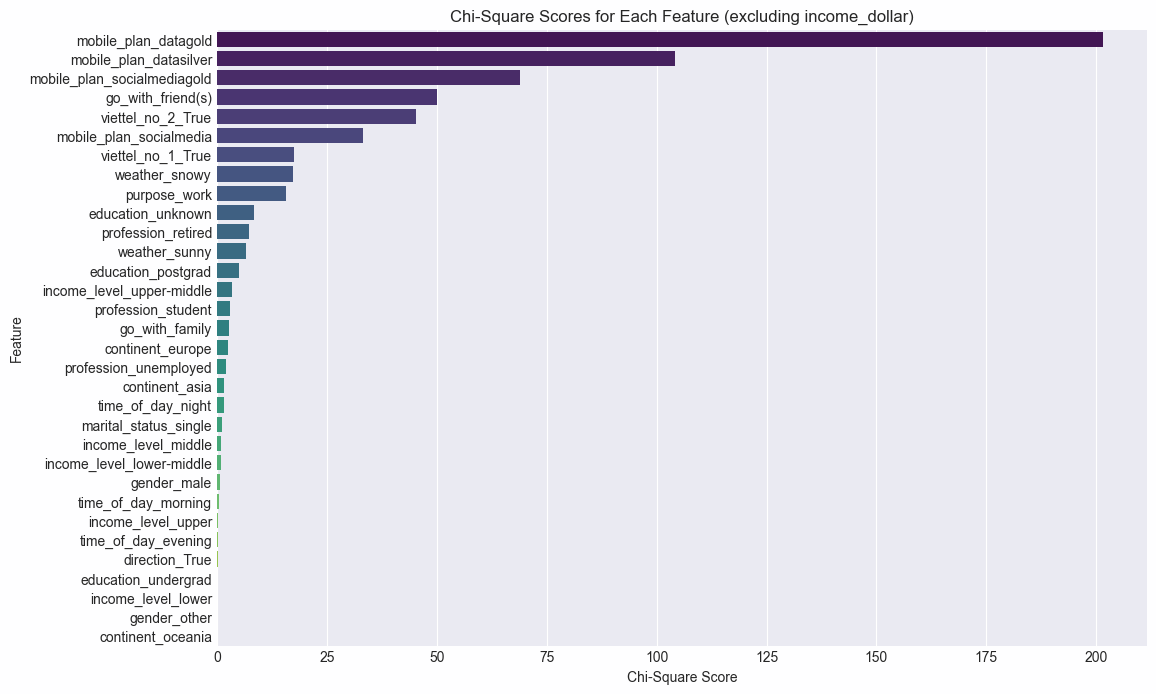

In [73]:
# Sử dụng SelectKBest với chi-square
selector = SelectKBest(score_func=chi2, k='all')  # 'all' để giữ tất cả các đặc trưng cho việc đánh giá
X_selected = selector.fit_transform(X_processed.drop(axis=1, columns=continuous_cols), y)

# Lấy ra các scores và p-values
scores = selector.scores_
p_values = selector.pvalues_

# Tạo DataFrame kết quả
feature_scores_chi2_wo_income = pd.DataFrame({'Feature': X_processed.drop(axis=1, columns=continuous_cols).columns, 'Score': scores, 'p-Value': p_values})
feature_scores_chi2_wo_income = feature_scores_chi2_wo_income.sort_values(by='Score', ascending=False)

# Biểu diễn biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores_chi2_wo_income, palette='viridis')
plt.title('Chi-Square Scores for Each Feature (excluding income_dollar)')
plt.xlabel('Chi-Square Score')
plt.ylabel('Feature')
plt.show()

## ANOVA


In [74]:
from sklearn.feature_selection import f_classif

# Usse SelectKBest to find the best features
selector = SelectKBest(score_func=f_classif, k='all')  # 'all' to keep all features
X_selected = selector.fit_transform(X_processed[continuous_cols], y)

# Get the scores and p-values
scores = selector.scores_
p_values = selector.pvalues_

# Create a DataFrame with the feature scores
feature_scores_anova = pd.DataFrame({'Feature': X_processed[continuous_cols].columns, 'Score': scores, 'p-Value': p_values})
feature_scores_anova = feature_scores_anova.sort_values(by='Score', ascending=False)
feature_scores_anova

,Feature,Score,p-Value
5,use_2GB_to_4GB,13.514070,0.000237
1,fb_freq,12.049509,0.000519
4,use_less_than_2GB,11.752842,0.000608
8,score,6.145675,0.013177
2,yt_freq,4.951120,0.026079
3,insta_freq,4.020838,0.044948
0,age,3.945524,0.047003
7,children,3.657492,0.055825
6,income_dollar,0.059310,0.807591


- Ý nghĩa của F-value: Giá trị F cao chỉ ra rằng đặc trưng đó có thể phân biệt tốt giữa các lớp của biến mục tiêu.
- p-value: p-value đi kèm cho biết mức độ xác suất của việc quan sát thấy giá trị F này trong trường hợp giả thuyết không (null hypothesis) là đúng. Giá trị p-value nhỏ cho thấy sự khác biệt quan sát được là có ý nghĩa thống kê và không phải do ngẫu nhiên.


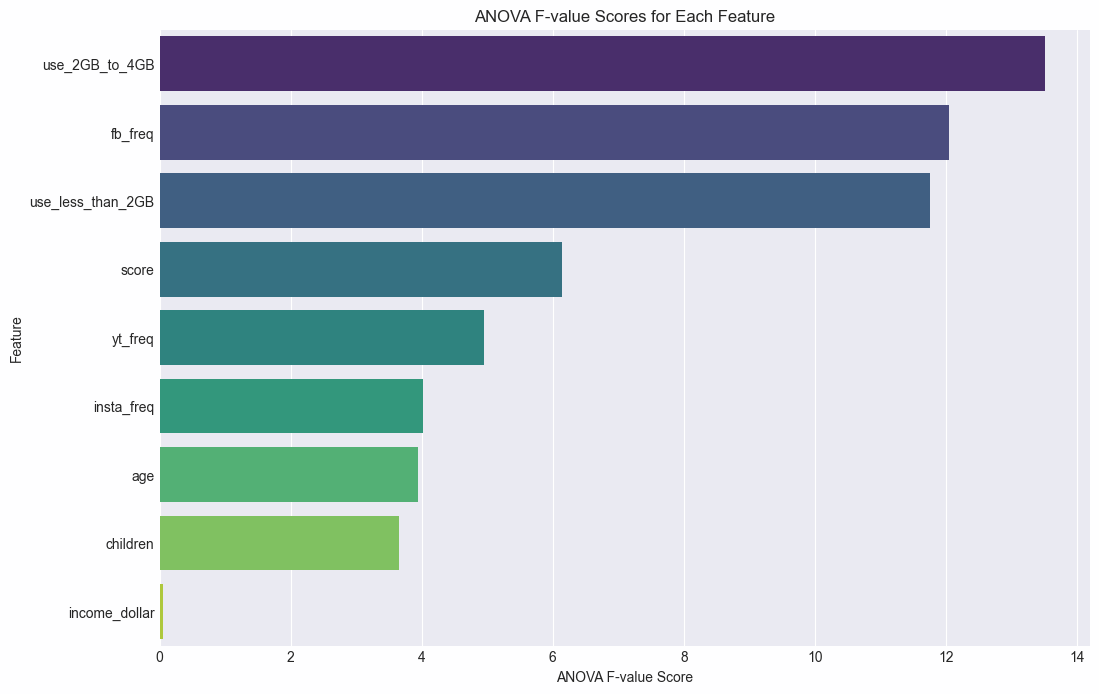

In [75]:
# Biểu diễn biểu đồ
plt.figure(figsize=(12, 8))
sns.barplot(x='Score', y='Feature', data=feature_scores_anova, palette='viridis')
plt.title('ANOVA F-value Scores for Each Feature')
plt.xlabel('ANOVA F-value Score')
plt.ylabel('Feature')
plt.show()

# Feature engineering


## Social media


In [76]:
def sm_ext(df, threshold):
  sm_avg_usage = df[['fb_freq', 'yt_freq', 'insta_freq']].apply(lambda x: x.sum(), axis=1)
  df['sm_ext'] = sm_avg_usage.apply(lambda x: True if x > threshold else False)

sm_ext(model_input_1, 10)
sm_ext(model_test, 10)

## use_less_than_2GB and use_2GB_to_4GB


In [77]:
def usage_ext(df):
  usage = ['use_less_than_2GB', 'use_2GB_to_4GB']
  for x in usage:
    range = 1.5
    IQR = df[x].quantile(0.75) - df[x].quantile(0.25)
    upper_bound = df[x].quantile(0.75) + (IQR * range)

    df[f"{x}_ext"] = df[x].apply(lambda y: True if y > upper_bound else False)

usage_ext(model_input_1)
usage_ext(model_test)

## education


In [78]:
def education_abn(df):
  df['education_abn'] = df['education'].apply(lambda x: True if x == 'unknown' else False)

education_abn(model_input_1)
education_abn(model_test)

## score


In [79]:
def score_ext(df):
  range = 1.5
  IQR = df['score'].quantile(0.75) - df['score'].quantile(0.25)
  upper_bound = df['score'].quantile(0.75) + (IQR * range)

  df['score_ext'] = df['score'].apply(lambda y: True if y > upper_bound else False)

score_ext(model_input_1)
score_ext(model_test)

# EDA

In [80]:
temp_df = pd.DataFrame(data=np.zeros((eda_df.shape[0], 1)))
eda = eda_df.merge(temp_df, left_index=True, right_index=True)
eda = eda.drop(columns=0)

sm_ext(eda, 10)
usage_ext(eda)
education_abn(eda)
score_ext(eda)

## Univariate Analysis
### Gender viz

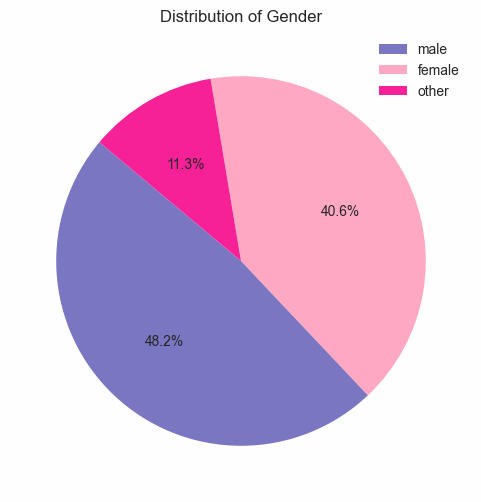

In [81]:
# Count the occurrences of each unique value in the 'gender' column
gender_count = eda['gender'].value_counts()

# Calculate the percentage of each value
gender_percentages = gender_count / gender_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(gender_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Gender')
plt.legend( labels=gender_percentages.index)
plt.show()

### Age viz

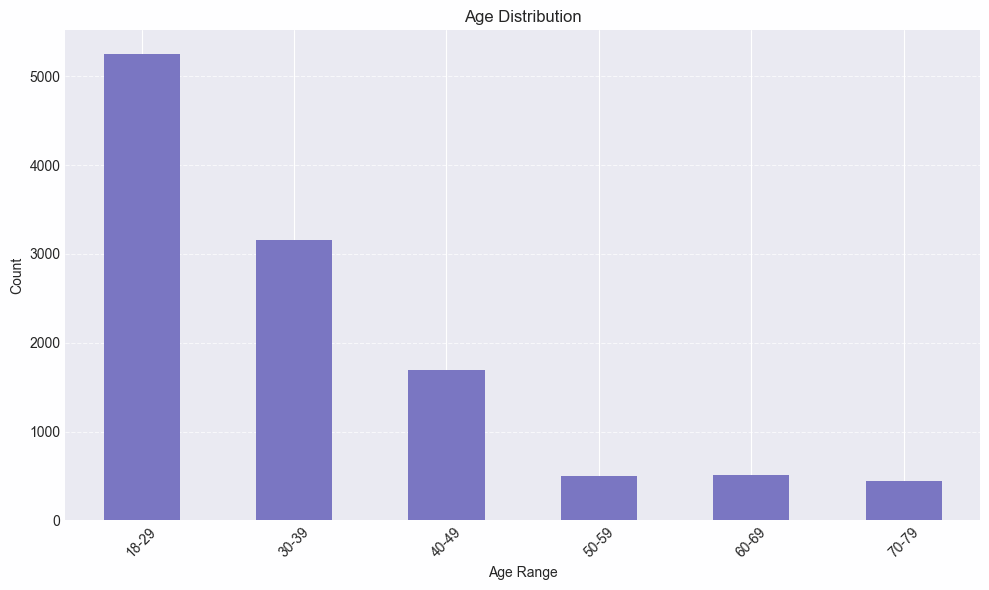

In [82]:
age_ranges = {
    '18-29': (18, 29),
    '30-39': (30, 39),
    '40-49': (40, 49),
    '50-59': (50, 59),
    '60-69': (60, 69),
    '70-79': (70, 79)
}

# Function to assign age range
def assign_age_range(age):
    for age_range, range_ in age_ranges.items():
        if range_[0] <= age <= range_[1]:
            return age_range
    return 'Unknown'


# Count occurrences of each age range
age_range_counts =eda['age'].apply(assign_age_range).value_counts()

# Sort the age ranges based on their natural order
age_range_counts = age_range_counts.sort_index()

# Plotting
plt.figure(figsize=(10, 6))
age_range_counts.plot(kind='bar')
plt.title('Age Distribution')
plt.xlabel('Age Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Education viz

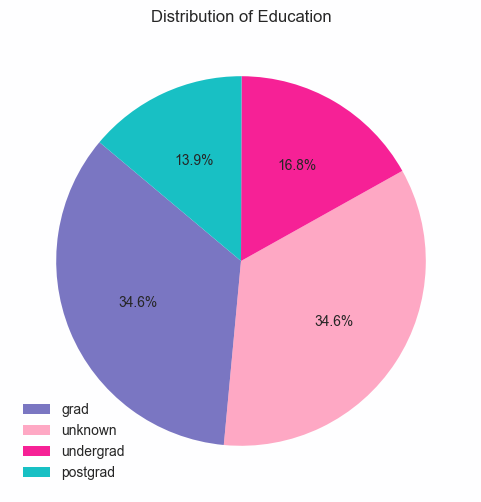

In [83]:
# Count the occurrences of each unique value in the 'education' column
education_count = eda['education'].value_counts()

# Calculate the percentage of each value
education_percentages = education_count / education_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(education_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Education')
plt.legend( labels=education_percentages.index)
plt.show()

### Profession viz

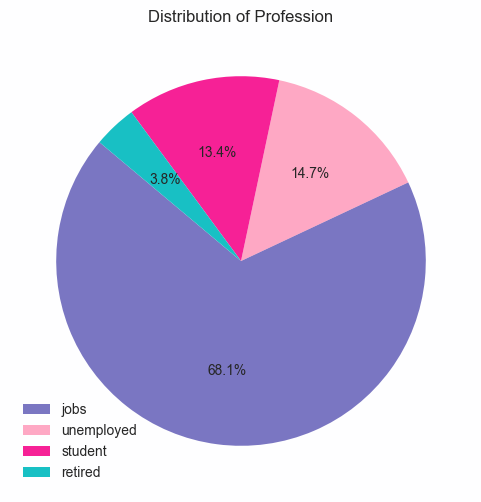

In [84]:
# Count the occurrences of each unique value in the 'profession' column 
profession_count = eda['profession'].value_counts()

# Calculate the percentage of each value
profession_percentages = profession_count / profession_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(profession_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Profession')
plt.legend( labels=profession_percentages.index)
plt.show()

### Continent viz

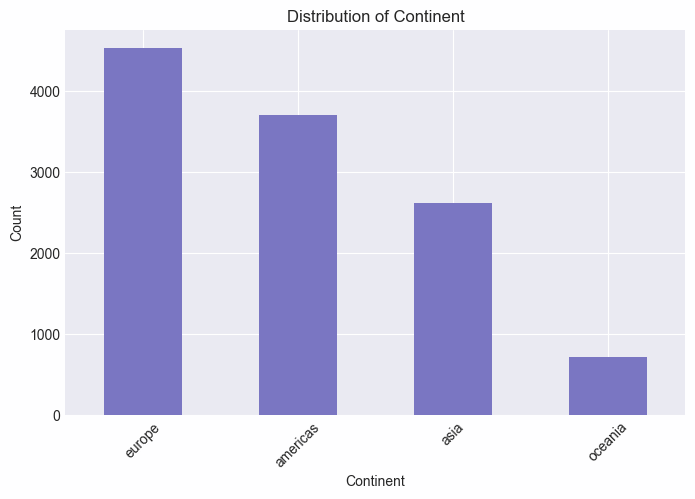

In [85]:
# Count the occurrences of each unique value in the 'continent' column
continent_counts = eda['continent'].value_counts()

# Create the bar chart
plt.figure(figsize=(8, 5))
continent_counts.plot(kind='bar')
plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Distribution of Continent')
plt.xticks(rotation=45)
plt.show()

### Income Level viz

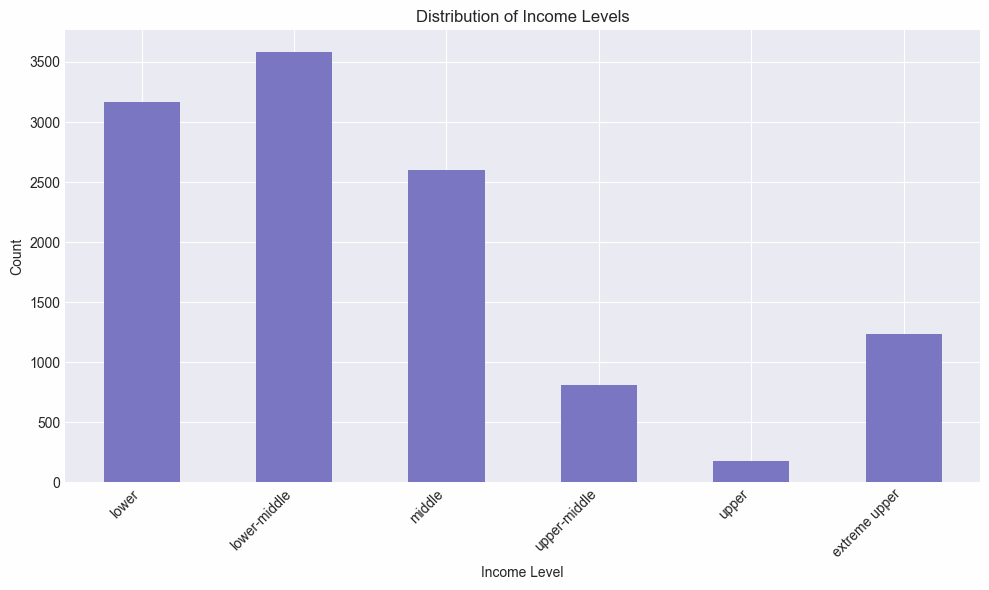

In [86]:
# Count the occurrences of each unique value in the 'income_level' column
income_level_counts = eda['income_level'].value_counts()

# Define the order of income levels for plotting
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Create the bar chart with specified order
plt.figure(figsize=(10, 6))  # Adjust the figure size if necessary
income_level_counts.loc[income_order].plot(kind='bar')  # Ensure order matches 'income_order'
plt.xlabel('Income Level')
plt.ylabel('Count')
plt.title('Distribution of Income Levels')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

### Marital Status

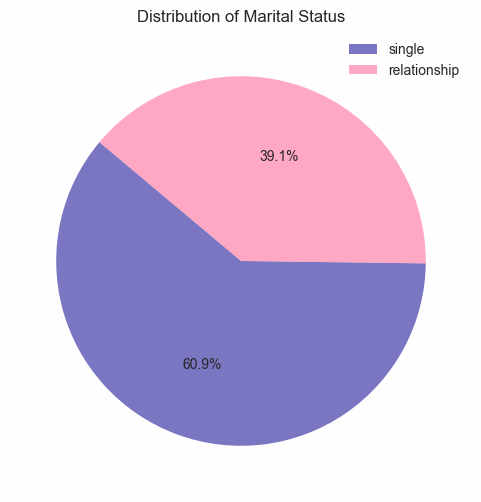

In [87]:
# Count the occurrences of each unique value in the 'marital_status' column 
marital_status_count = eda['marital_status'].value_counts()

# Calculate the percentage of each value
marital_status_percentages = marital_status_count / marital_status_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(marital_status_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Marital Status')
plt.legend( labels=marital_status_percentages.index)
plt.show()

### Children viz

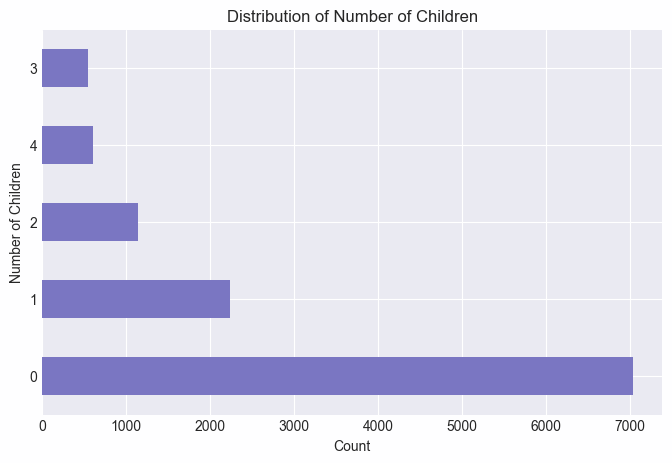

In [88]:
# Count the occurrences of each unique value in the 'children' column
children_counts = eda['children'].value_counts()

# Create the horizontal bar chart
plt.figure(figsize=(8, 5))
children_counts.plot(kind='barh')
plt.xlabel('Count')
plt.ylabel('Number of Children')
plt.title('Distribution of Number of Children')
plt.show()

### Go_with viz

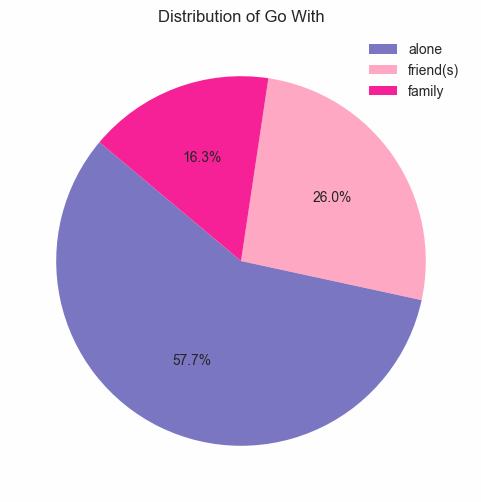

In [89]:
# Count the occurrences of each unique value in the 'go_with' column 
go_with_count = eda['go_with'].value_counts()

# Calculate the percentage of each value
go_with_percentages = go_with_count / go_with_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(go_with_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Go With')
plt.legend( labels=go_with_percentages.index)
plt.show()

### Weather viz

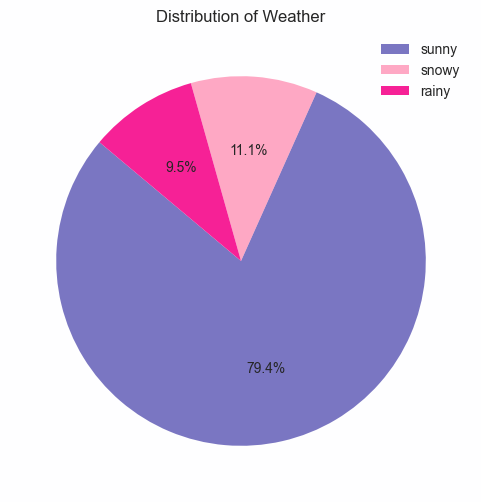

In [90]:
# Count the occurrences of each unique value in the 'weather' column 
weather_count = eda['weather'].value_counts()

# Calculate the percentage of each value
weather_percentages = weather_count / weather_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(weather_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Weather')
plt.legend( labels=weather_percentages.index)
plt.show()

### Purpose viz

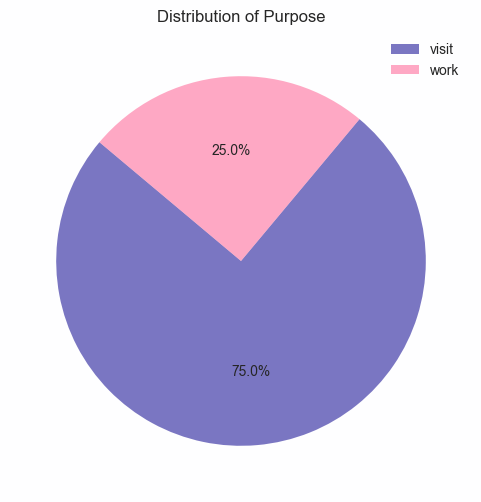

In [91]:
# Count the occurrences of each unique value in the 'purpose' column 
purpose_count = eda_df['purpose'].value_counts()

# Calculate the percentage of each value
purpose_percentages = purpose_count / purpose_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(purpose_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Purpose')
plt.legend( labels=purpose_percentages.index)
plt.show()

### Score viz

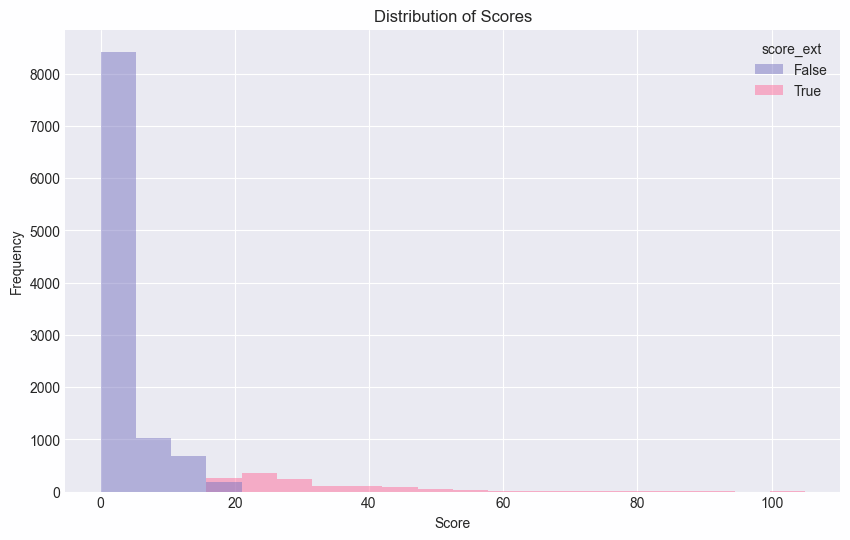

In [92]:
plt.figure(figsize=(10, 6))
sns.histplot(data=eda, x='score', bins=20, hue='score_ext', edgecolor=None)

plt.xlabel('Score')
plt.ylabel('Frequency')
plt.title('Distribution of Scores')

plt.show()

### Direction viz

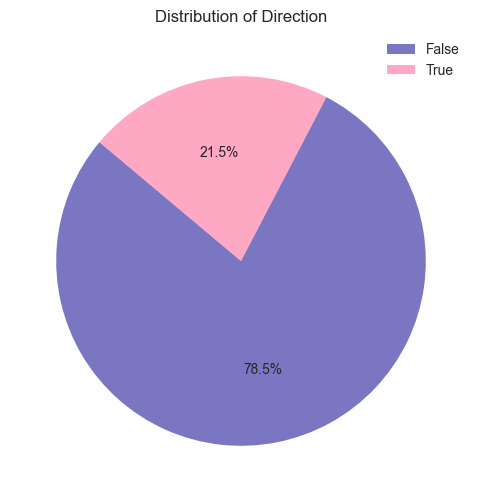

In [93]:
# Count the occurrences of each unique value in the 'direction' column 
direction_count = eda_df['direction'].value_counts()

# Calculate the percentage of each value
direction_percentages = direction_count / direction_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(direction_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Direction')
plt.legend( labels=direction_percentages.index)
plt.show()

### Time of day viz

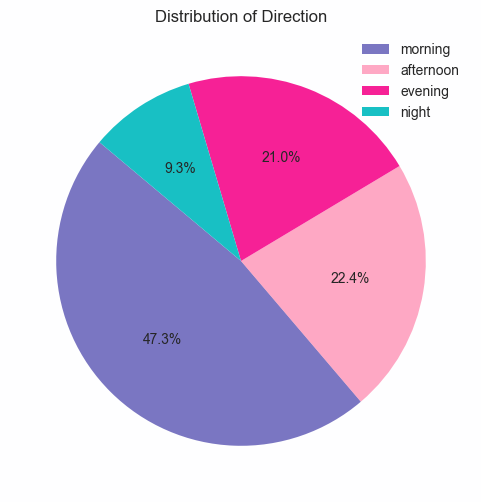

In [94]:
# Count the occurrences of each unique value in the 'time_of_day' column 
time_of_day_count = eda_df['time_of_day'].value_counts()

# Calculate the percentage of each value
time_of_day_percentages = time_of_day_count / time_of_day_count.sum() * 100

# Create the pie chart
plt.figure(figsize=(6, 6))
plt.pie(time_of_day_percentages, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Direction')
plt.legend( labels=time_of_day_percentages.index)
plt.show()

## Multivariate Analysis
### Age x Income level x Gender viz

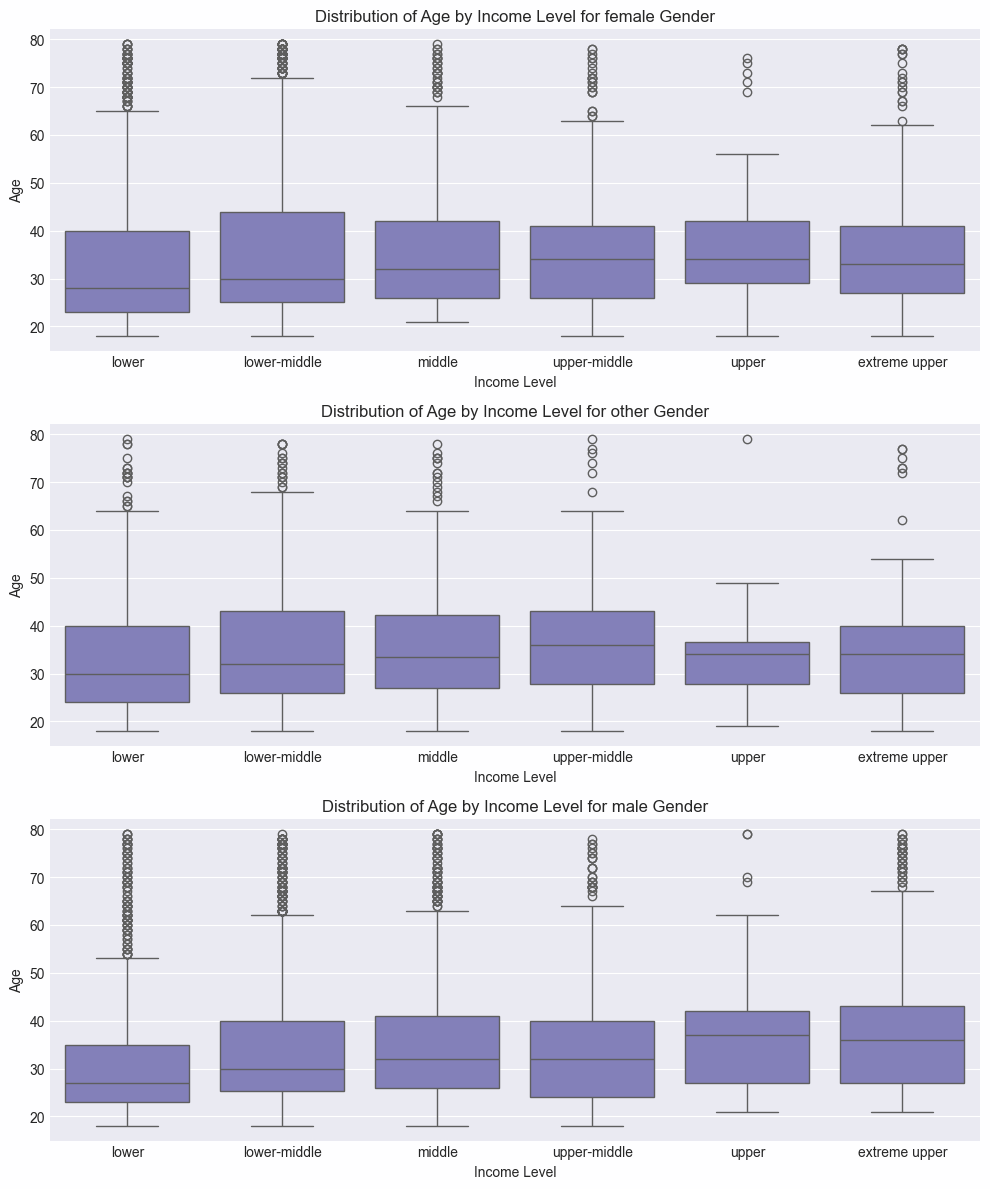

In [95]:
# Define the order for the income levels
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Convert the income_level column to a categorical type with the specified order
eda['income_level'] = pd.Categorical(eda['income_level'], categories=income_order, ordered=True)

# Get the unique values of the gender column
genders = eda['gender'].unique()

# Create individual plots for each gender
plt.figure(figsize=(10, 12))  # Adjust the height to fit three plots vertically

for i, gender in enumerate(genders):
    plt.subplot(len(genders), 1, i + 1)
    sns.boxplot(x='income_level', y='age', data=eda[eda['gender'] == gender], order=income_order)
    plt.title(f'Distribution of Age by Income Level for {gender} Gender')
    plt.xlabel('Income Level')
    plt.ylabel('Age')

plt.tight_layout()
plt.show()

### Continent x Income level

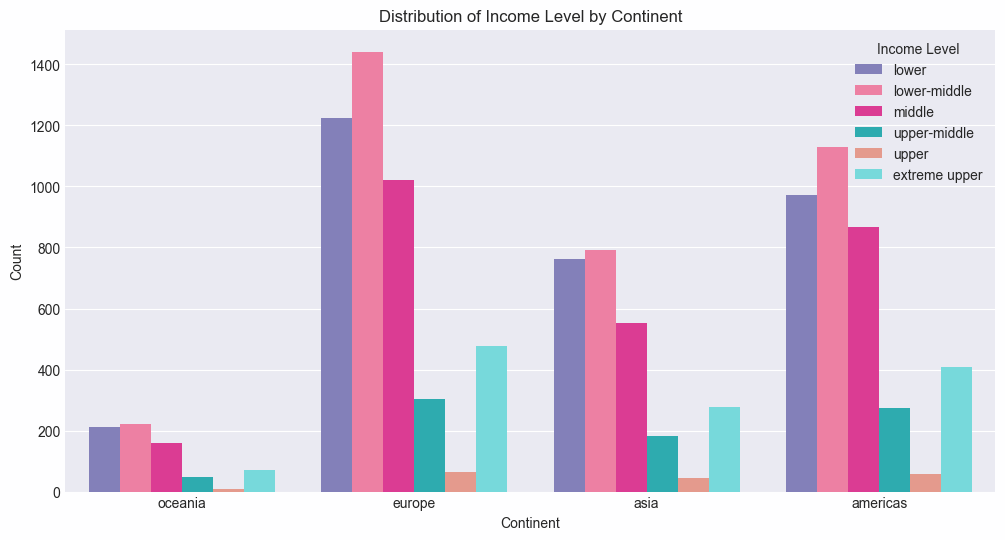

In [96]:
# Copy the DataFrame to avoid modifying the original
df_copy = eda.copy()

# Define the order for the income levels
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Convert the income_level column to a categorical type with the specified order in the copy
df_copy['income_level'] = pd.Categorical(df_copy['income_level'], categories=income_order, ordered=True)

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=df_copy, x='continent', hue='income_level', order=df_copy['continent'].unique(), hue_order=income_order)

# Set plot labels and title
plt.xlabel('Continent')
plt.ylabel('Count')
plt.title('Distribution of Income Level by Continent')

# Show the plot
plt.legend(title='Income Level')
plt.show()

### Education x Income level

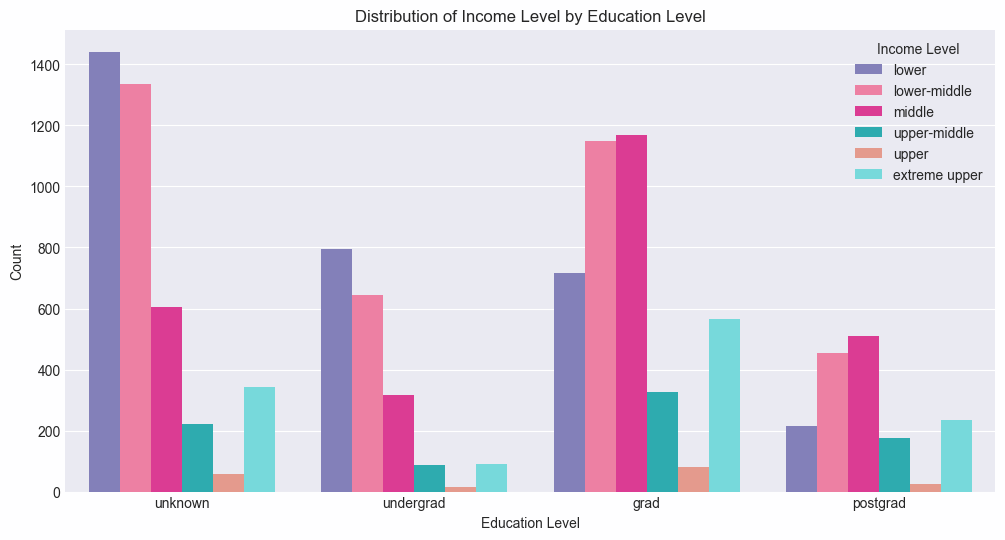

In [97]:
# Copy the DataFrame to avoid modifying the original
df_copy = eda.copy()

# Define the order for the income levels
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Define the order for the education levels
education_order = ['unknown', 'undergrad', 'grad', 'postgrad']

# Convert the income_level and education columns to categorical types with the specified orders in the copy
df_copy['income_level'] = pd.Categorical(df_copy['income_level'], categories=income_order, ordered=True)
df_copy['education'] = pd.Categorical(df_copy['education'], categories=education_order, ordered=True)

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=df_copy, x='education', hue='income_level', order=education_order, hue_order=income_order)

# Set plot labels and title
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.title('Distribution of Income Level by Education Level')

# Show the plot
plt.legend(title='Income Level')
plt.show()

### Profession x Income level

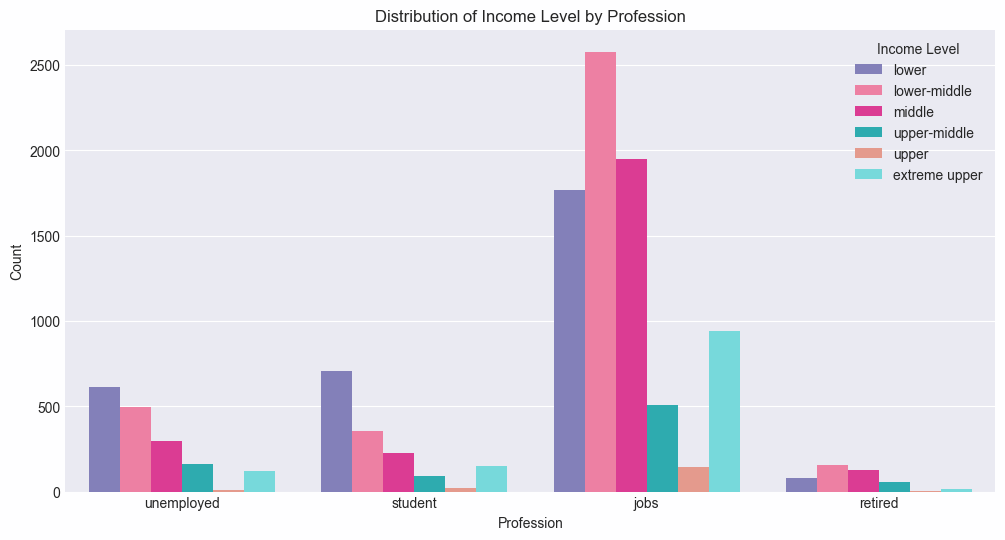

In [98]:
# Copy the DataFrame to avoid modifying the original
df_copy = eda.copy()

# Define the order for the income levels
income_order = ['lower', 'lower-middle', 'middle', 'upper-middle', 'upper', 'extreme upper']

# Define the order for the education levels
profession_order = ['unemployed', 'student', 'jobs', 'retired']

# Convert the income_level and education columns to categorical types with the specified orders in the copy
df_copy['income_level'] = pd.Categorical(df_copy['income_level'], categories=income_order, ordered=True)
df_copy['profession'] = pd.Categorical(df_copy['profession'], categories=profession_order, ordered=True)

# Create a grouped bar chart
plt.figure(figsize=(12, 6))
sns.countplot(data=df_copy, x='profession', hue='income_level', order=profession_order, hue_order=income_order)

# Set plot labels and title
plt.xlabel('Profession')
plt.ylabel('Count')
plt.title('Distribution of Income Level by Profession')

# Show the plot
plt.legend(title='Income Level')
plt.show()

### Education x Profession

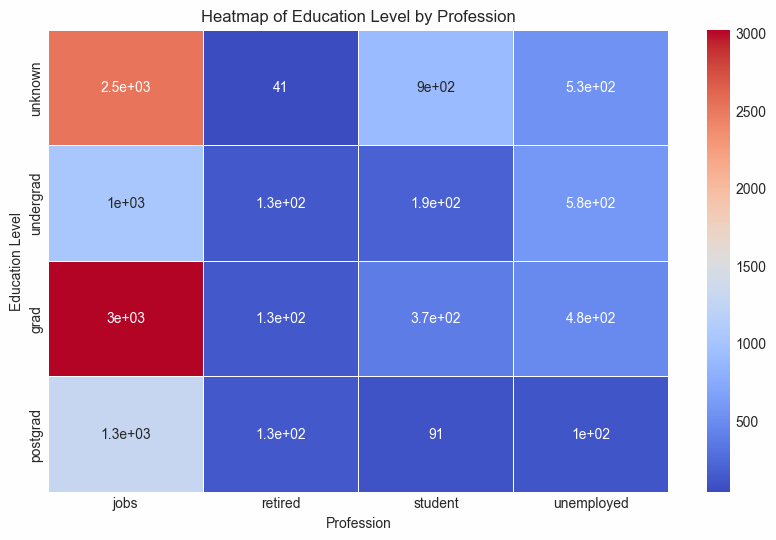

In [99]:
# Copy the DataFrame to avoid modifying the original
df_copy = eda.copy()

# Define the order for the education levels
education_order = ['unknown', 'undergrad', 'grad', 'postgrad']

# Convert the education column to a categorical type with the specified order in the copy
df_copy['education'] = pd.Categorical(df_copy['education'], categories=education_order, ordered=True)

# Create a crosstab between education and profession
crosstab = pd.crosstab(df_copy['education'], df_copy['profession'])

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, cmap='coolwarm', cbar=True, linewidths=.5)

# Set plot labels and title
plt.xlabel('Profession')
plt.ylabel('Education Level')
plt.title('Heatmap of Education Level by Profession')

# Show the plot
plt.show()

### Marital status x Children

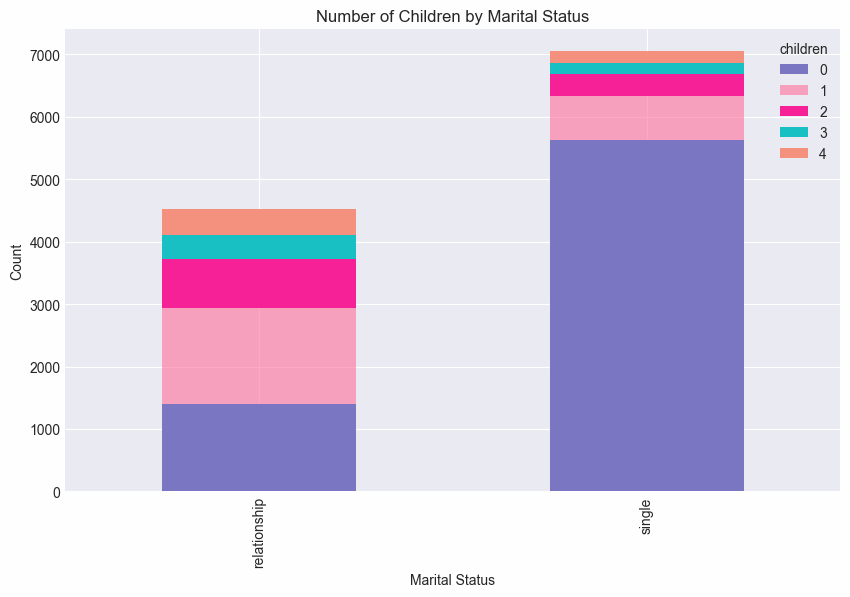

In [100]:
# Copy the DataFrame to avoid modifying the original
df_copy = eda.copy()

# Create a crosstab between marital_status and children
crosstab = pd.crosstab(df_copy['marital_status'], df_copy['children'])

# Create the stacked bar chart
crosstab.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.title('Number of Children by Marital Status')

# Show the plot
plt.show()

### Accept x Mean CVR by Mobile Plan

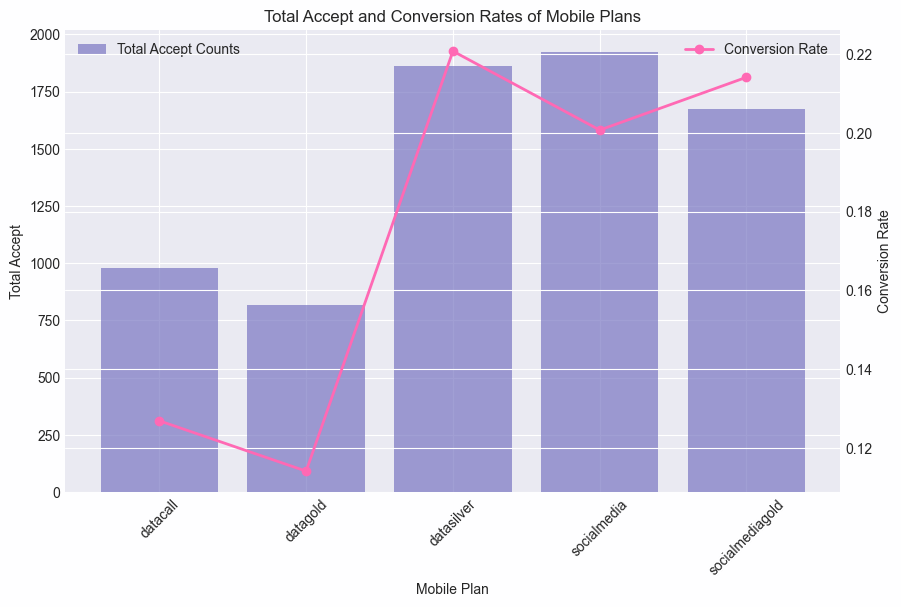

In [101]:
# Calculate counts of accept for each mobile plan
accept_counts = mobile_plan_user.groupby('mobile_plan')['accept'].sum().sort_index()

# Calculate conversion rates
plan_counts = mobile_plan_user['mobile_plan'].value_counts().sort_index()
conversion_rates = accept_counts / plan_counts

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for total accept counts
ax1.bar(accept_counts.index, accept_counts.values, alpha=0.7, label='Total Accept Counts')
ax1.set_xlabel('Mobile Plan')
ax1.set_ylabel('Total Accept')
ax1.set_title('Total Accept and Conversion Rates of Mobile Plans')
ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')

# Line plot for conversion rates
ax2 = ax1.twinx()
ax2.plot(conversion_rates.index, conversion_rates.values, color = 'hotpink', marker='o', linestyle='-', linewidth=2, label='Conversion Rate')
ax2.set_ylabel('Conversion Rate')
ax2.legend(loc='upper right')

plt.show()

### Frequency (fb, yt, ins) x Gender

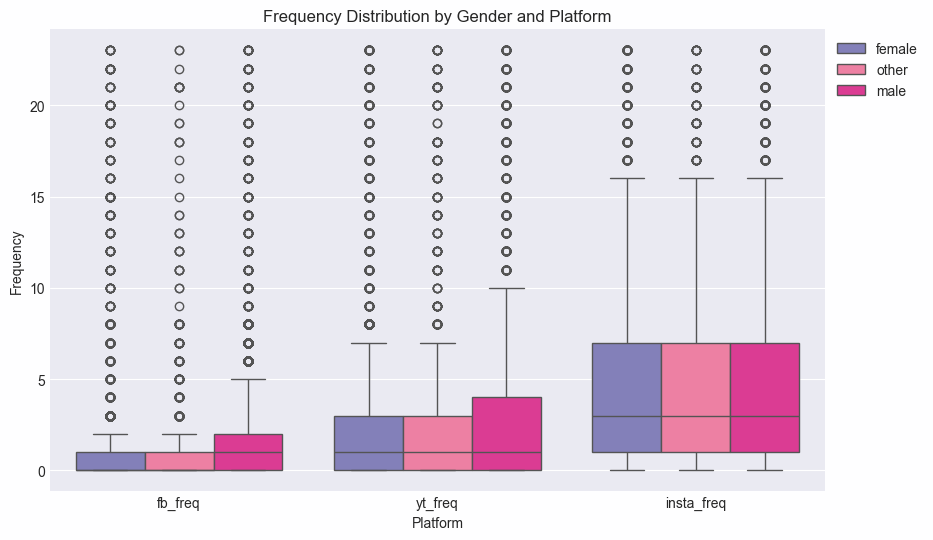

In [102]:
# Melt the dataframe to "long" format for easier plotting
melted_df = pd.melt(eda, id_vars=['gender'], value_vars=['fb_freq', 'yt_freq', 'insta_freq'],
                    var_name='platform', value_name='frequency')

# Plotting using Seaborn
plt.figure(figsize=(10, 6))
sns.boxplot(x='platform', y='frequency', hue='gender', data=melted_df)

# Move legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.title('Frequency Distribution by Gender and Platform')
plt.xlabel('Platform')
plt.ylabel('Frequency')
plt.show()

### Gender x Accept x Mean CVR

In [103]:
# Group by 'id' and aggregate 'mobile_plan' and 'accept'
mobile_plan_user_agg = mobile_plan_user.groupby('id').agg({
    'mobile_plan': 'size',  # Count occurrences of 'mobile_plan' for each 'id'
    'accept': 'sum'  # Sum 'accept' values for each 'id'
}).reset_index()

# Rename columns as per the desired output
mobile_plan_user_agg.columns = ['id', 'mobile_plan_recommended', 'total_accept']

# Calculate conversion_rate as percentage
mobile_plan_user_agg['conversion_rate'] = (mobile_plan_user_agg['total_accept'] / mobile_plan_user_agg['mobile_plan_recommended']) * 100

In [104]:
eda_mobile_plan = pd.merge(eda, mobile_plan_user_agg, on='id', how='left')

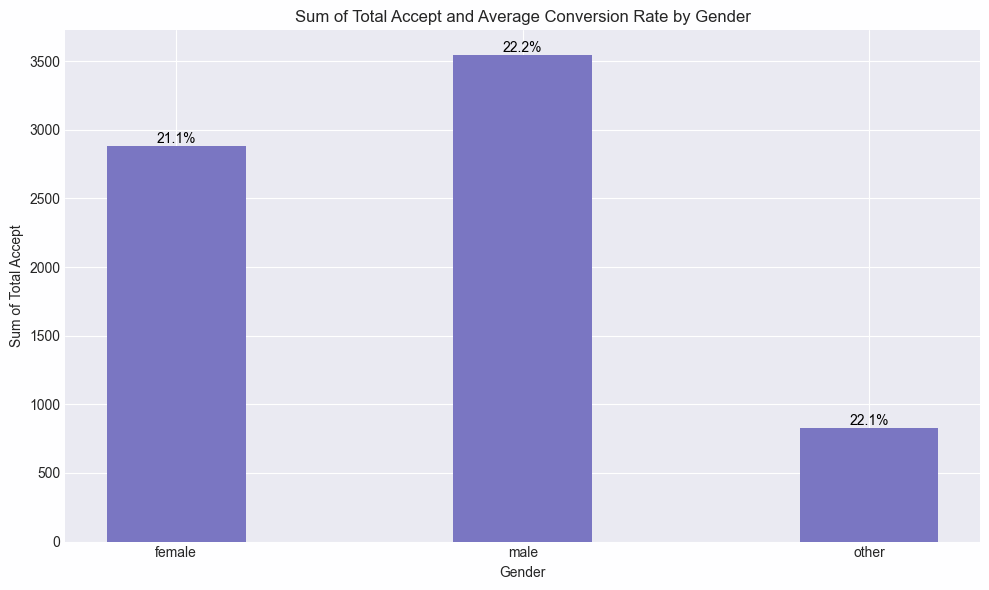

In [105]:
# Grouping by gender to calculate sum of total_accept and mean of conversion_rate
grouped_data = eda_mobile_plan.groupby('gender').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for sum of total_accept
bar_width = 0.4
bars = ax.bar(grouped_data['gender'], grouped_data['total_accept'], width=bar_width, label='Sum of total_accept')

# Adding labels and title
ax.set_xlabel('Gender')
ax.set_ylabel('Sum of Total Accept')
ax.set_title('Sum of Total Accept and Average Conversion Rate by Gender')

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars, grouped_data['conversion_rate']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
            ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

### Age x Accept x Mean CVR

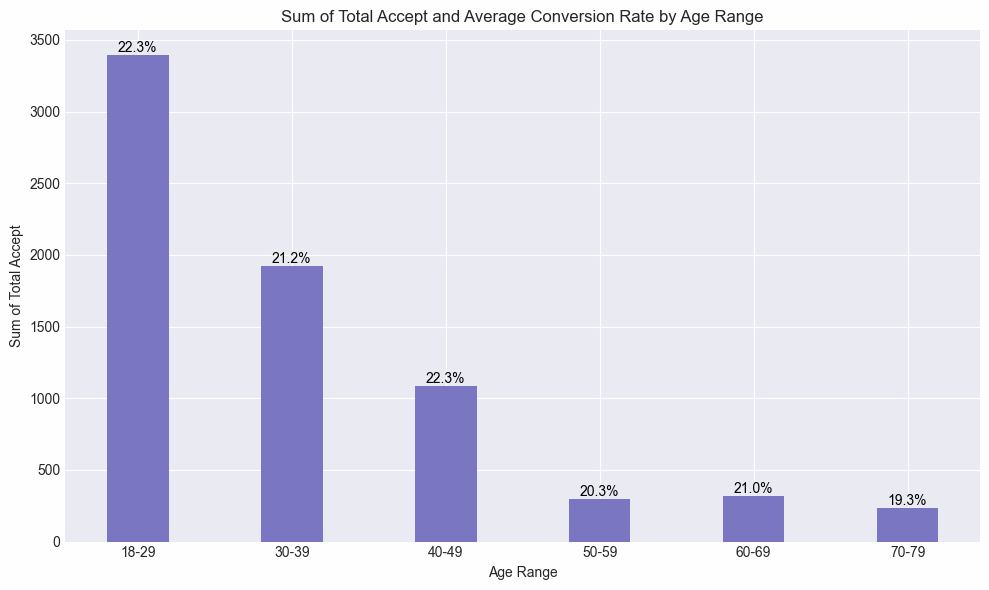

In [106]:
# Define age ranges
age_ranges = {
    '18-29': (18, 29),
    '30-39': (30, 39),
    '40-49': (40, 49),
    '50-59': (50, 59),
    '60-69': (60, 69),
    '70-79': (70, 79)
}

# Function to assign age range
def assign_age_range(age):
    for age_range, range_ in age_ranges.items():
        if range_[0] <= age <= range_[1]:
            return age_range
    return 'Unknown'

# Apply age range assignment
eda_mobile_plan['age_range'] = eda_mobile_plan['age'].apply(assign_age_range)

# Grouping by age range to calculate sum of total_accept and mean of conversion_rate
grouped_data = eda_mobile_plan.groupby('age_range').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for sum of total_accept
bar_width = 0.4
bars = ax.bar(grouped_data['age_range'], grouped_data['total_accept'], width=bar_width, label='Sum of total_accept')

# Adding labels and title
ax.set_xlabel('Age Range')
ax.set_ylabel('Sum of Total Accept')
ax.set_title('Sum of Total Accept and Average Conversion Rate by Age Range')

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars, grouped_data['conversion_rate']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
            ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

eda_mobile_plan = eda_mobile_plan.drop(columns='age_range')

### Income level x Accept x Mean CVR

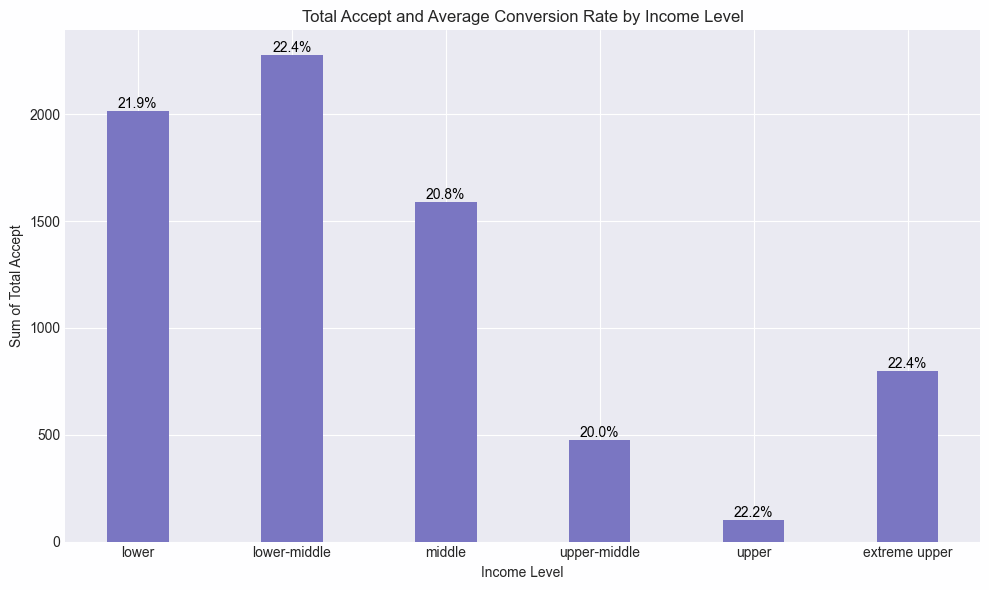

In [107]:
# Grouping by gender to calculate sum of total_accept and mean of conversion_rate
grouped_data = eda_mobile_plan.groupby('income_level').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for sum of total_accept
bar_width = 0.4
bars = ax.bar(grouped_data['income_level'], grouped_data['total_accept'], width=bar_width, label='Sum of total_accept')

# Adding labels and title
ax.set_xlabel('Income Level')
ax.set_ylabel('Sum of Total Accept')
ax.set_title('Total Accept and Average Conversion Rate by Income Level')

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars, grouped_data['conversion_rate']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
            ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

### Continent x Accept x Mean CVR

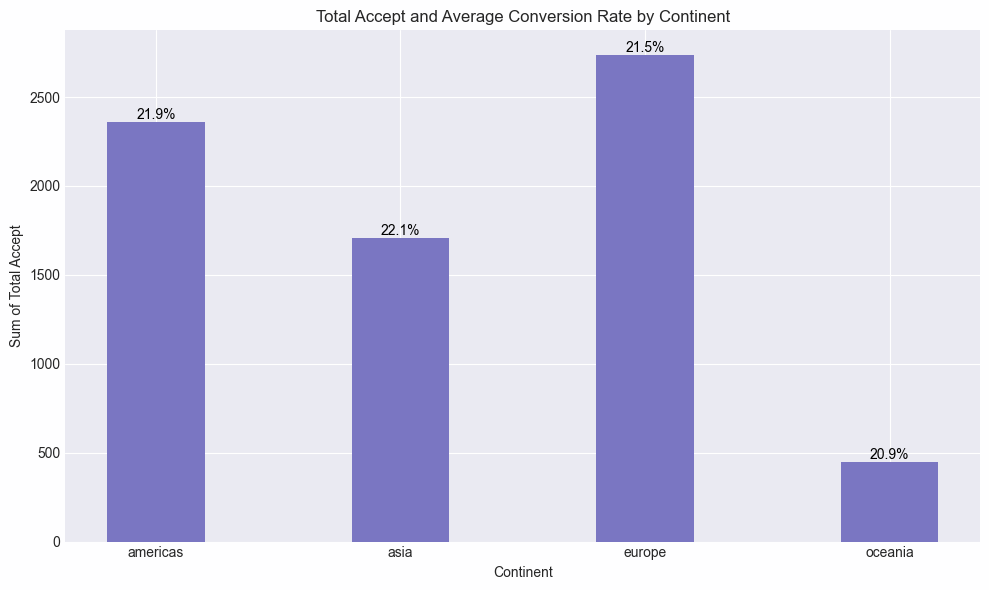

In [108]:
# Grouping by gender to calculate sum of total_accept and mean of conversion_rate
grouped_data = eda_mobile_plan.groupby('continent').agg({
    'total_accept': 'sum',
    'conversion_rate': 'mean'
}).reset_index()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar plot for sum of total_accept
bar_width = 0.4
bars = ax.bar(grouped_data['continent'], grouped_data['total_accept'], width=bar_width, label='Sum of total_accept')

# Adding labels and title
ax.set_xlabel('Continent')
ax.set_ylabel('Sum of Total Accept')
ax.set_title('Total Accept and Average Conversion Rate by Continent')

# Adding text labels for average conversion_rate on top of each bar
for bar, rate in zip(bars, grouped_data['conversion_rate']):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{rate:.1f}%', 
            ha='center', va='bottom', color='black', fontsize=10)

# Adjusting layout and displaying the plot
fig.tight_layout()
plt.show()

### Hành vi sử dụng 4G x Accept

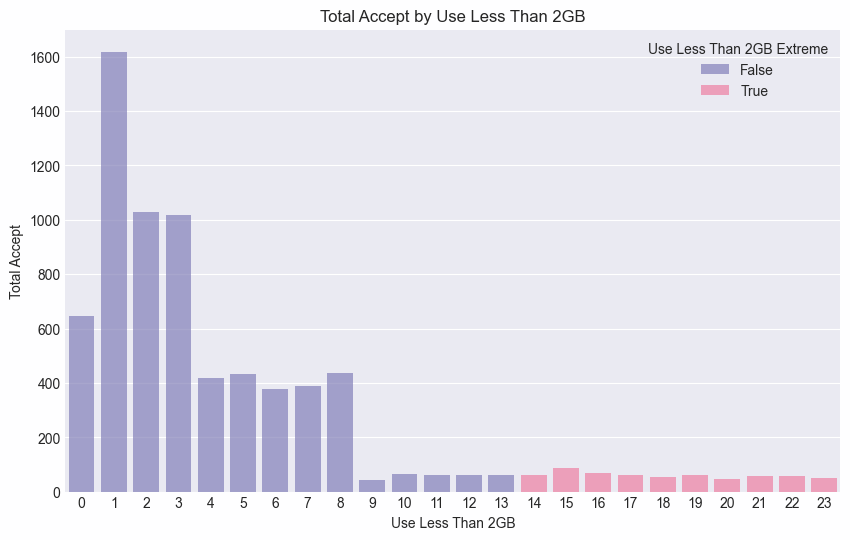

In [109]:
# Group by 'use_less_than_2GB' and calculate sum of 'total_accept'
grouped_data = eda_mobile_plan.groupby(['use_less_than_2GB', 'use_less_than_2GB_ext']).agg({
    'total_accept': 'sum'
}).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot with hue
sns.barplot(x='use_less_than_2GB', y='total_accept', hue='use_less_than_2GB_ext', data=grouped_data, alpha=0.7)
plt.xlabel('Use Less Than 2GB')
plt.ylabel('Total Accept')
plt.title('Total Accept by Use Less Than 2GB')
plt.legend(title='Use Less Than 2GB Extreme')

plt.show()

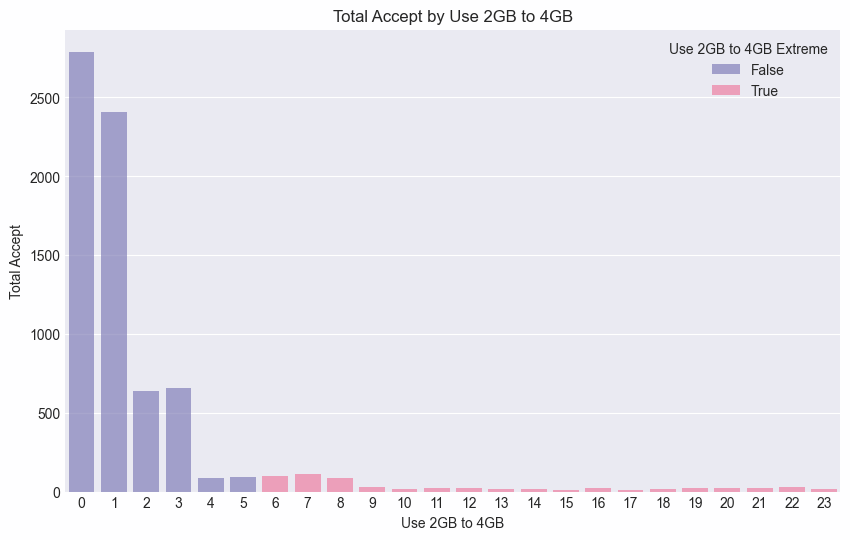

In [110]:
# Group by 'use_less_than_4GB' and calculate sum of 'total_accept'
grouped_data = eda_mobile_plan.groupby(['use_2GB_to_4GB', 'use_2GB_to_4GB_ext']).agg({
    'total_accept': 'sum'
}).reset_index()

# Plotting
plt.figure(figsize=(10, 6))

# Bar plot with hue
sns.barplot(x='use_2GB_to_4GB', y='total_accept', hue='use_2GB_to_4GB_ext', data=grouped_data, alpha=0.7)
plt.xlabel('Use 2GB to 4GB')
plt.ylabel('Total Accept')
plt.title('Total Accept by Use 2GB to 4GB')
plt.legend(title='Use 2GB to 4GB Extreme')

plt.show()

### Nhận biết gói Viettel x Direction

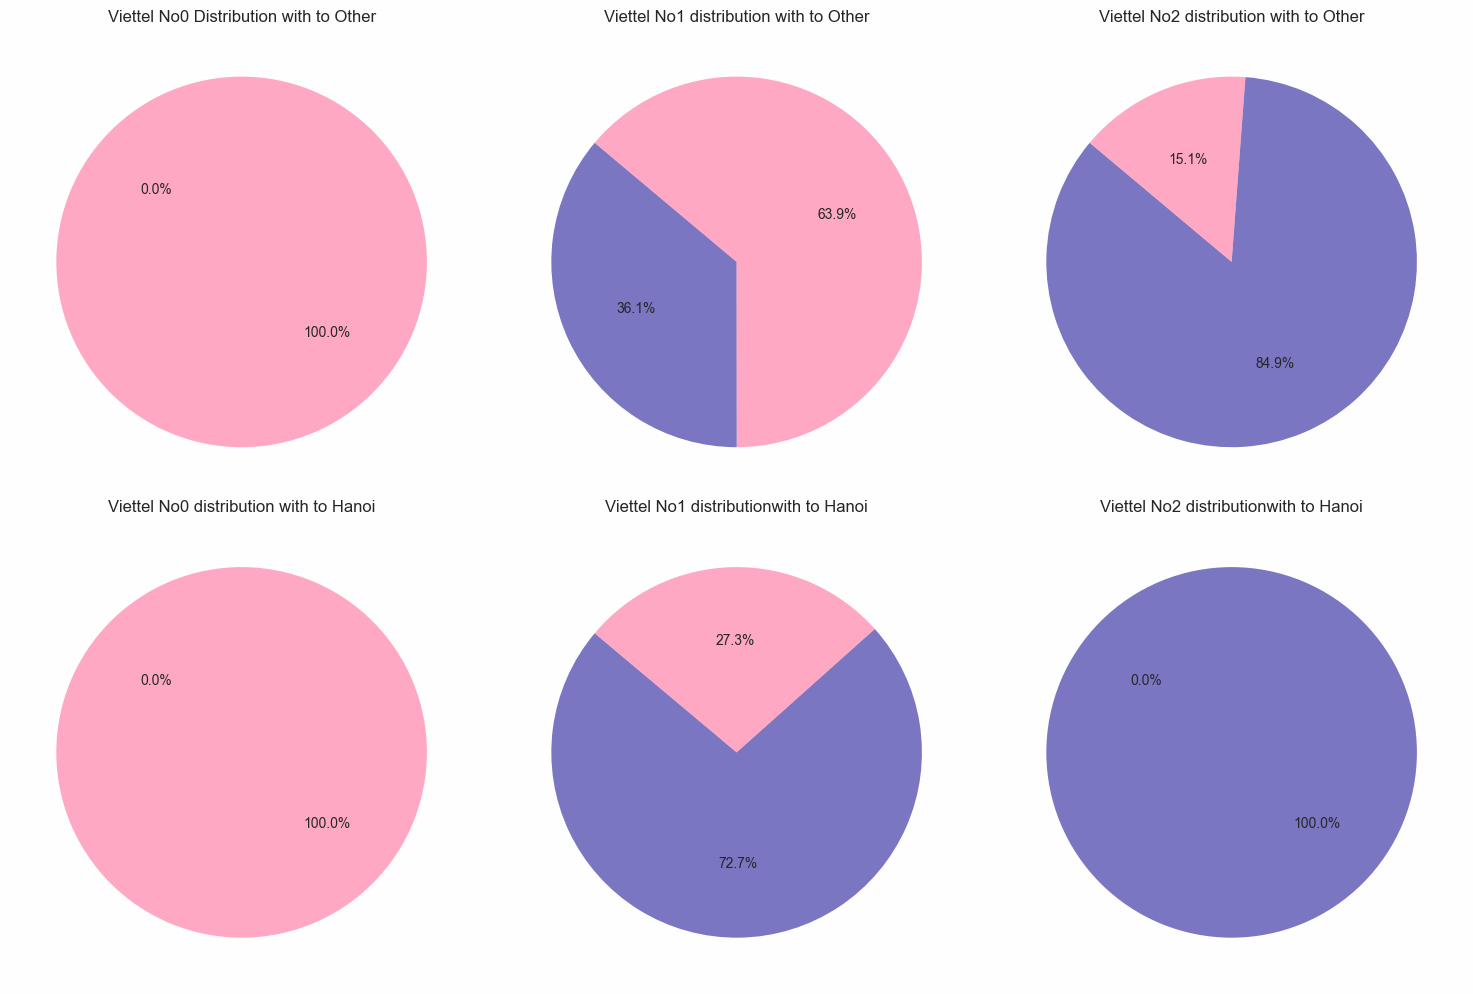

In [111]:
# Calculate proportions for direction 0 and 1
dir_0_counts = eda[eda['direction'] == 0][['viettel_no_0', 'viettel_no_1', 'viettel_no_2']].sum()
dir_1_counts = eda[eda['direction'] == 1][['viettel_no_0', 'viettel_no_1', 'viettel_no_2']].sum()

# Plot pie charts
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

# For direction 0
sizes = [eda[(eda['direction'] == 0) & (eda['viettel_no_0'] == 0)].shape[0], 
         eda[(eda['direction'] == 0) & (eda['viettel_no_0'] == 1)].shape[0]]
axes[0, 0].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[0, 0].set_title('Viettel No0 Distribution with to Other')

sizes = [eda[(eda['direction'] == 0) & (eda['viettel_no_1'] == 0)].shape[0], 
         eda[(eda['direction'] == 0) & (eda['viettel_no_1'] == 1)].shape[0]]
axes[0, 1].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[0, 1].set_title('Viettel No1 distribution with to Other')

sizes = [eda[(eda['direction'] == 0) & (eda['viettel_no_2'] == 0)].shape[0], 
         eda[(eda['direction'] == 0) & (eda['viettel_no_2'] == 1)].shape[0]]
axes[0, 2].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[0, 2].set_title('Viettel No2 distribution with to Other')

# For direction 1
sizes = [eda[(eda['direction'] == 1) & (eda['viettel_no_0'] == 0)].shape[0], 
         eda[(eda['direction'] == 1) & (eda['viettel_no_0'] == 1)].shape[0]]
axes[1, 0].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[1, 0].set_title('Viettel No0 distribution with to Hanoi')

sizes = [eda[(eda['direction'] == 1) & (eda['viettel_no_1'] == 0)].shape[0], 
         eda[(eda['direction'] == 1) & (eda['viettel_no_1'] == 1)].shape[0]]
axes[1, 1].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[1, 1].set_title('Viettel No1 distributionwith to Hanoi')

sizes = [eda[(eda['direction'] == 1) & (eda['viettel_no_2'] == 0)].shape[0], 
         eda[(eda['direction'] == 1) & (eda['viettel_no_2'] == 1)].shape[0]]
axes[1, 2].pie(sizes, labels=None, autopct='%1.1f%%', startangle=140)
axes[1, 2].set_title('Viettel No2 distributionwith to Hanoi')


plt.tight_layout()
plt.show()

### Purpose x Direction

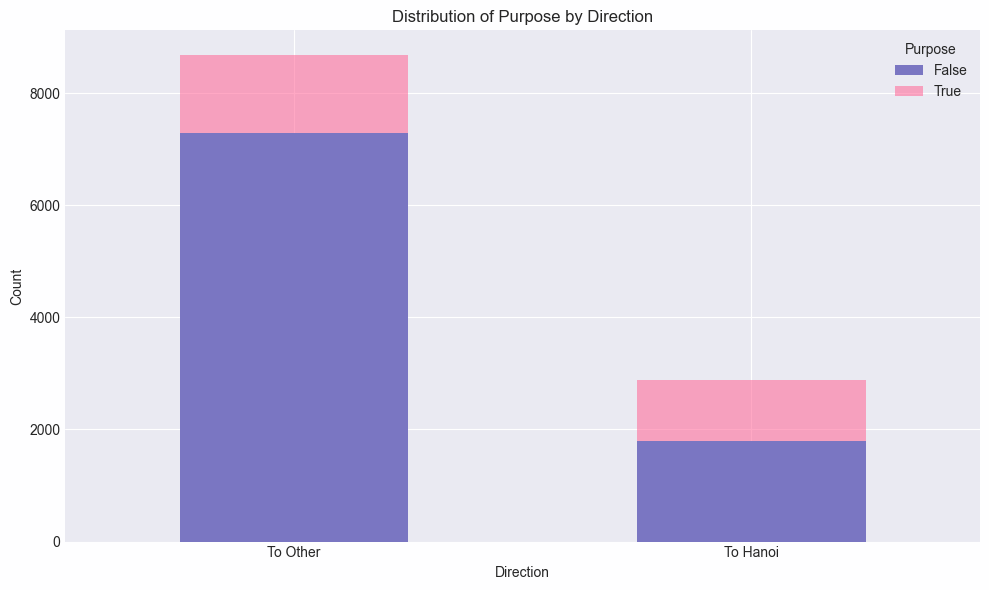

In [112]:
# Calculate the counts of each purpose by direction
counts = eda.groupby(['purpose', 'direction']).size().unstack(fill_value=0)

# Plotting the stacked bar chart
fig, ax = plt.subplots(figsize=(10, 6))

counts.plot(kind='bar', stacked=True, ax=ax)

# Adding titles and labels
ax.set_title('Distribution of Purpose by Direction')
ax.set_xlabel('Direction')
ax.set_ylabel('Count')
ax.set_xticks([0, 1])
ax.set_xticklabels(['To Other', 'To Hanoi'], rotation=0)

# Add legend
ax.legend(title='Purpose')

plt.tight_layout()
plt.show()

### Purpose x Go_with

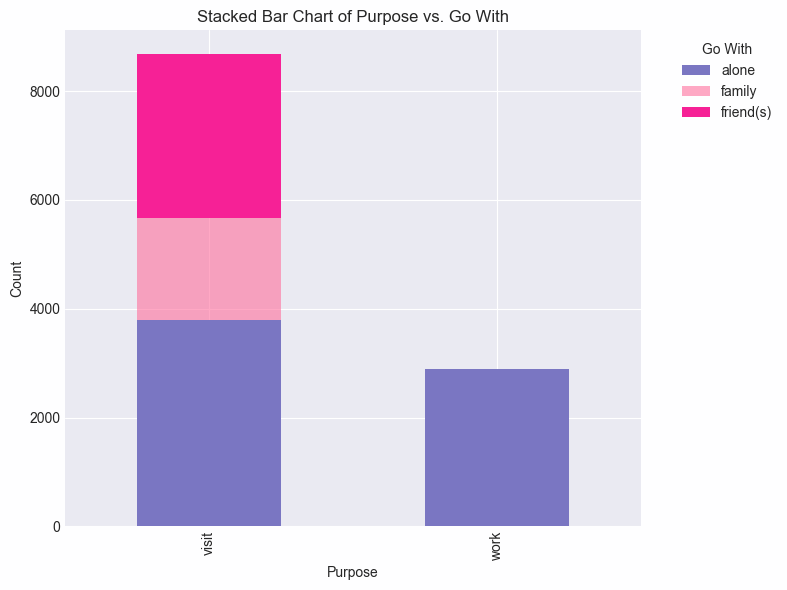

In [113]:
# Prepare the data
counts = eda.groupby(['purpose', 'go_with']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, figsize=(8, 6))

# Adding labels and title for clarity
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Purpose vs. Go With')
plt.legend(title='Go With', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

### Go_with x Weather

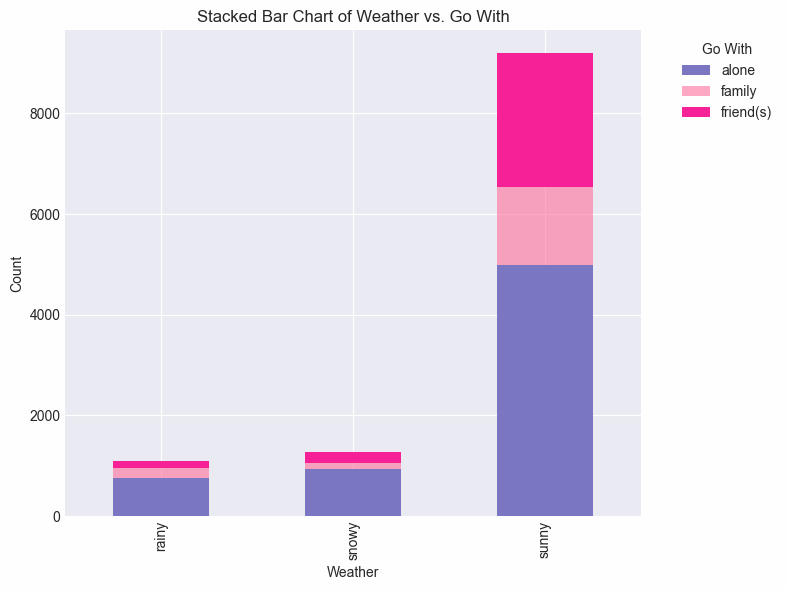

In [114]:
# Prepare the data
counts = eda.groupby(['weather', 'go_with']).size().unstack(fill_value=0)

# Plot the stacked bar chart
ax = counts.plot(kind='bar', stacked=True, figsize=(8, 6))

# Adding labels and title for clarity
plt.xlabel('Weather')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Weather vs. Go With')
plt.legend(title='Go With', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

# Show the plot
plt.show()

## Variable Relationships

In [115]:
eda_categorical = eda_mobile_plan[['gender','education', 'profession','continent', 'income_level', 'marital_status', 'purpose', 'go_with', 'weather', 'time_of_day']]
eda_binary = eda_mobile_plan[['viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'sm_ext', 'use_less_than_2GB_ext', 'use_2GB_to_4GB_ext', 'education_abn', 'score_ext']]
eda_continuous = eda_mobile_plan[['fb_freq', 'yt_freq', 'insta_freq', 'use_less_than_2GB', 'use_2GB_to_4GB',  'mobile_plan_recommended', 'total_accept', 'conversion_rate']]

### Chi-Square Test for categorical variables

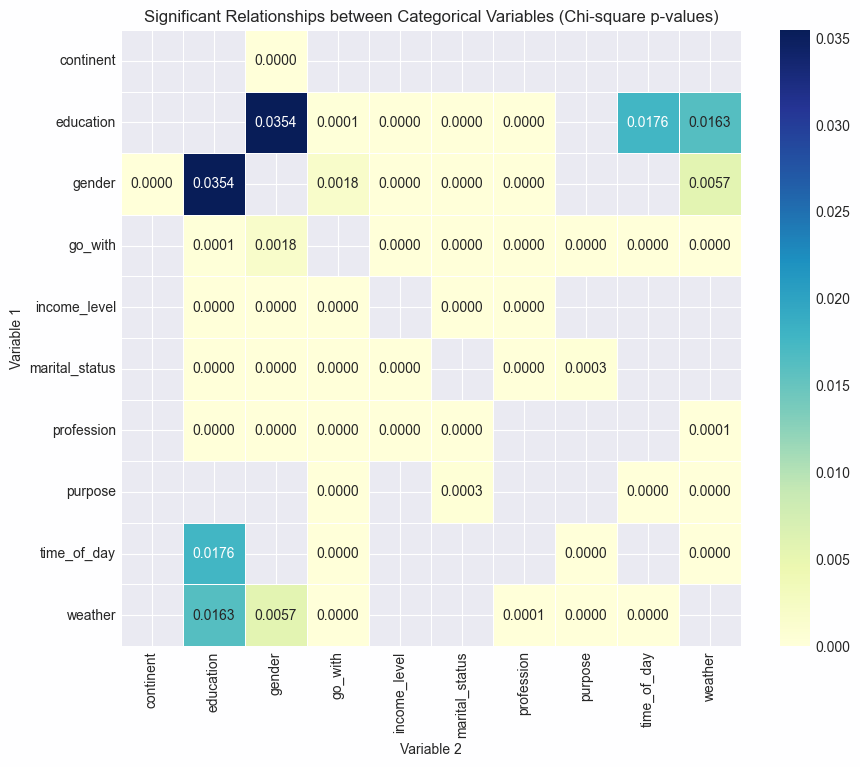

In [116]:
from scipy.stats import chi2_contingency
# Significance level (alpha)
alpha = 0.05

# List to store significant relationships
significant_relationships = []

# Perform Chi-square tests and filter significant relationships
for var1 in eda_categorical:
    for var2 in eda_categorical:
        if var1 != var2:  # Avoid testing the same variable against itself
            contingency_table = pd.crosstab(eda_mobile_plan[var1], eda_mobile_plan[var2])
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if p < alpha:
                significant_relationships.append((var1, var2, p))

# Visualize significant relationships as a heatmap
if significant_relationships:
    # Prepare data for heatmap
    data = pd.DataFrame(significant_relationships, columns=['Variable 1', 'Variable 2', 'p-value'])
    pivoted_data = data.pivot(index='Variable 1', columns='Variable 2', values='p-value')

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivoted_data, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5, fmt=".4f")
    plt.title('Significant Relationships between Categorical Variables (Chi-square p-values)')
    plt.show()
else:
    print("No significant relationships found.")

### Phi Coefficient for binary variables

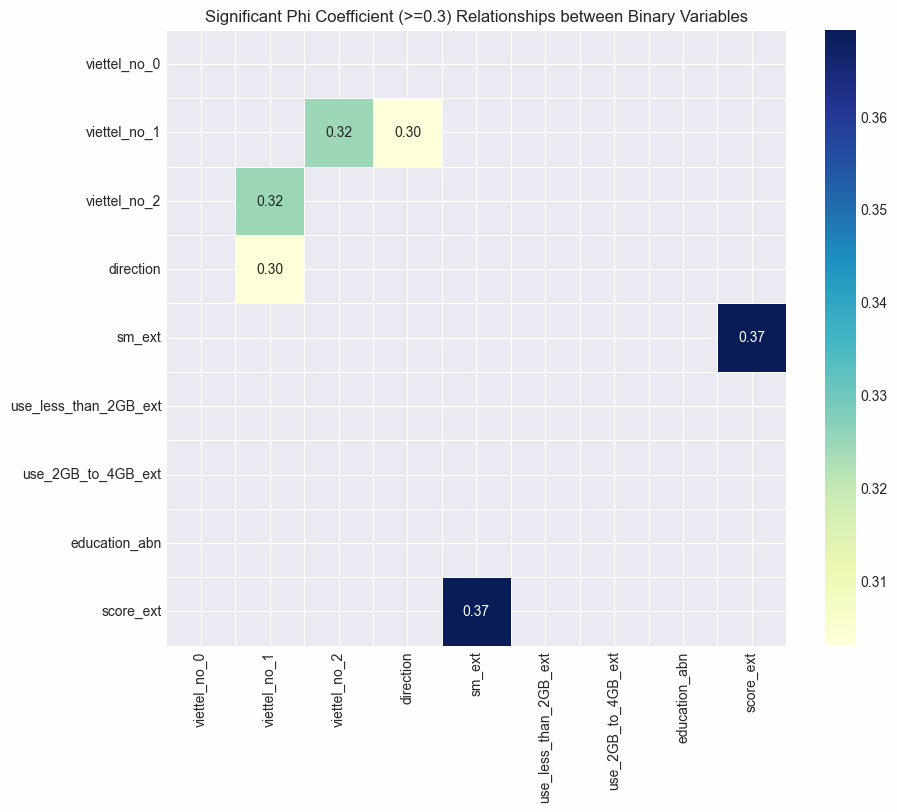

In [117]:
# Selecting only the binary variables for analysis
eda_binary = eda_mobile_plan[['viettel_no_0', 'viettel_no_1', 'viettel_no_2', 'direction', 'sm_ext', 'use_less_than_2GB_ext', 'use_2GB_to_4GB_ext', 'education_abn', 'score_ext']]

# Calculate Phi coefficient for each pair of binary variables
phi_coefficient_matrix = pd.DataFrame(index=eda_binary.columns, columns=eda_binary.columns, dtype=float)
for i, col_name in enumerate(eda_binary.columns):
    for j, other_col_name in enumerate(eda_binary.columns):
        if i != j:  # Avoid calculating for the same column
            phi_coefficient = np.abs(np.corrcoef(eda_binary[col_name], eda_binary[other_col_name])[0, 1])
            # Set a significance threshold (example: 0.3)
            significance_threshold = 0.3
            if phi_coefficient >= significance_threshold:
                phi_coefficient_matrix.loc[col_name, other_col_name] = phi_coefficient
            else:
                phi_coefficient_matrix.loc[col_name, other_col_name] = np.nan  # Hide non-significant relationships

# Visualize significant Phi coefficient relationships as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(phi_coefficient_matrix, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5, fmt=".2f")
plt.title(f'Significant Phi Coefficient (>={significance_threshold}) Relationships between Binary Variables')
plt.show()

### Correlation Coefficient for continuous variables

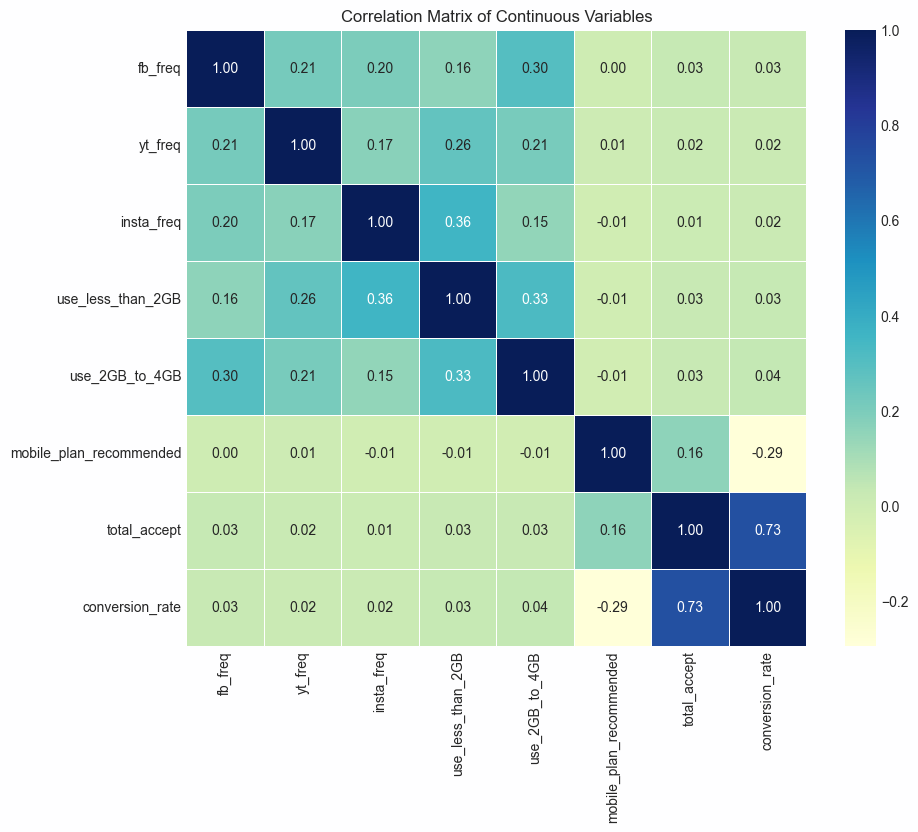

In [118]:
# Calculate correlation matrix
correlation_matrix = eda_continuous.corr()

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', cbar=True, linewidths=.5, fmt=".2f")
plt.title('Correlation Matrix of Continuous Variables')
plt.show()

# Model evaluation metrics


1. **Accuracy (Độ chính xác)**: Đây là tỉ lệ phần trăm của các dự đoán đúng trên tổng số mẫu kiểm tra. Độ chính xác cao cho thấy mô hình dự đoán đúng nhiều.

2. **Hamming Loss**: Đây là tỉ lệ lỗi Hamming, đo lường tỉ lệ các nhãn bị phân loại sai. Chỉ số này càng thấp càng tốt.

3. **Precision (Độ chính xác dự đoán dương)**: Đây là tỉ lệ các dự đoán dương đúng trên tổng số dự đoán dương. Độ chính xác cao cho thấy mô hình ít báo động giả.

4. **Recall (Độ nhạy)**: Đây là tỉ lệ các dự đoán dương đúng trên tổng số mẫu dương thực sự. Độ nhạy cao cho thấy mô hình ít bỏ sót các trường hợp dương.

5. **F1-score**: Đây là trung bình điều hòa của Precision và Recall, cung cấp một thước đo cân bằng giữa hai chỉ số này. F1-score cao cho thấy mô hình cân bằng tốt giữa độ chính xác và độ nhạy.


# Model building


In [119]:
import joblib
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [120]:
# Set random seed
seed = 42

# Initialize classifiers
models = {
    'KNeighbors Classifier': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=seed),
    'Random Forest Classifier': RandomForestClassifier(random_state=seed),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=seed),
    'AdaBoost Classifier': AdaBoostClassifier(random_state=seed),
    'XGBoost Classifier': XGBClassifier(random_state=seed)
}
# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

## Single model

### Function

#### Train function


In [121]:
def train_single_model(X, y, models, kf, approach, param_grid=None):
    # Encode categorical columns
    check = (X.dtypes == 'object') | (X.dtypes == 'category') | (X.dtypes == 'bool')
    object_columns = list(check[check].index)

    # Initialize preprocessor
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), X.columns.difference(object_columns)),
            ('cat', OneHotEncoder(), object_columns)
        ],
        remainder='passthrough'
    )

    # Initialize results
    results = []
    model_results = []
    best_model = None
    best_f1_score = 0
    best_params = None  # Variable to store best parameters

    # Train each model
    for name, model in models.items():
        print(f"Training {name}...")
        accuracy_cv_scores = []
        hamming_cv_losses = []
        precision_scores = []
        recall_scores = []
        f1_scores = []

        # Train the model using KFold
        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            # Initialize pipeline
            pipeline = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('classifier', model)
            ])
            
            if param_grid:
                grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, scoring='f1_weighted', cv=kf, n_jobs=-1)
                grid_search.fit(X_train, y_train)
                best_estimator = grid_search.best_estimator_
                y_pred = best_estimator.predict(X_test)
            else:
                pipeline.fit(X_train, y_train)
                y_pred = pipeline.predict(X_test)

            # Metrics
            acc = accuracy_score(y_test, y_pred)
            hamming = hamming_loss(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='weighted')
            recall = recall_score(y_test, y_pred, average='weighted')
            f1 = f1_score(y_test, y_pred, average='weighted')

            accuracy_cv_scores.append(acc)
            hamming_cv_losses.append(hamming)
            precision_scores.append(precision)
            recall_scores.append(recall)
            f1_scores.append(f1)

        # Calculate the mean of each metric
        mean_accuracy = np.mean(accuracy_cv_scores)
        mean_hamming_loss = np.mean(hamming_cv_losses)
        mean_precision = np.mean(precision_scores)
        mean_recall = np.mean(recall_scores)
        mean_f1_score = np.mean(f1_scores)

        # Save model results
        model_results.append({
            'Model': name,
            'Mean Accuracy': mean_accuracy,
            'Mean Hamming Loss': mean_hamming_loss,
            'Mean Precision': mean_precision,
            'Mean Recall': mean_recall,
            'Mean F1-score': mean_f1_score
        })

        # Update the best model if current model is better based on F1-score
        if mean_f1_score > best_f1_score:
            best_f1_score = mean_f1_score
            best_model = grid_search.best_estimator_ if param_grid else pipeline
            best_params = grid_search.best_params_ if param_grid else None  # Save best parameters

    # Save the best model for the current label
    joblib.dump(best_model, f'best_model_{approach}.pkl')

    # Print best parameters if GridSearchCV was used
    if best_params:
        print(f"Best parameters for {name}: {best_params}")

    # Convert results to DataFrame and sort by Mean F1-score
    model_results_df = pd.DataFrame(model_results)
    model_results_df = model_results_df.sort_values(by='Mean F1-score', ascending=False)

    return model_results_df

#### Test function


In [122]:
def test_single_model(X, y, model_to_test):
  # Load best model from file
  model = joblib.load(model_to_test)

  # Predict on the test set
  y_pred = model.predict(X)

  # Ví dụ tính toán các độ đo
  accuracy_test = accuracy_score(y, y_pred)
  hamming_loss_test = hamming_loss(y, y_pred)
  precision_test = precision_score(y, y_pred, average='weighted')
  recall_test = recall_score(y, y_pred, average='weighted')
  f1_test = f1_score(y, y_pred, average='weighted')

  # Tạo DataFrame chứa các độ đo
  metrics = {
    'Metric': ['F1-score', 'Accuracy', 'Hamming Loss', 'Precision', 'Recall'],
    'Value': [f1_test, accuracy_test, hamming_loss_test, precision_test, recall_test]}
  metrics_df = pd.DataFrame(metrics)
  return metrics_df

### Test set

- Single label


In [123]:
sm_ext(model_test, 10)
usage_ext(model_test)
education_abn(model_test)
score_ext(model_test)

# Split data into X_test and y_test
X_test = model_test.drop(axis=1, columns=['accept'])
y_test = model_test['accept']

- Multi label


In [124]:
df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
temp_df = eda_df_test.merge(df_mobile_plan, how='cross')

# Merge the dataframes
temp_df = temp_df.merge(mobile_plan_user_test, on=['id', 'mobile_plan'], how='left')
temp_df = temp_df.fillna(False)
temp_df = temp_df.pivot_table(index='id', columns='mobile_plan', values='accept', aggfunc='max', fill_value=False).reset_index()
ML_model_input = eda_df_test.merge(temp_df, on="id", how="left")

# drop columns
ML_model_input = ML_model_input.drop(axis=1, columns=to_drop)

sm_ext(ML_model_input, 10)
usage_ext(ML_model_input)
education_abn(ML_model_input)
score_ext(ML_model_input)

# Split data into X and y
ML_X_test = ML_model_input.drop(axis=1, columns=mobile_plans)
ML_y_test = ML_model_input[mobile_plans]

### Approach

#### Approach 1

Nguyên vẹn


In [125]:
# # Split data into X and y
# X1 = model_input_1.drop(axis=1, columns=['accept'])
# y1 = model_input_1['accept']

In [126]:
# ap1_result_df = train_single_model(X1, y1, models, kf, 'ap1')

In [127]:
# ap1_result_df

In [128]:
# ap1_test = test_single_model(X_test, y_test, 'best_model_ap1.pkl')
# ap1_test

Từ các giá trị trên, mô hình có độ chính xác tổng thể là khoảng 57.73%. Precision đạt 61.50%, chỉ ra rằng mô hình có khả năng dự đoán chính xác các mẫu dương một cách hiệu quả. Recall là 57.73%, cho thấy mô hình phát hiện được hầu hết các mẫu dương nhưng vẫn còn một số lượng bỏ sót. F1-score là 42.49%, thấp hơn so với độ chính xác và Precision, cho thấy sự cân bằng giữa Precision và Recall chưa đạt mức cao. Hamming Loss là 0.422705, biểu thị rằng có khoảng 42.27% các nhãn bị phân loại sai.


#### Approach 2

Dup 5


In [129]:
temp_df = eda_df.merge(df_mobile_plan, how='cross')

# Merge the dataframes
model_input_2 = temp_df.merge(mobile_plan_user, on=['id', 'mobile_plan'], how='left')
model_input_2 = model_input_2.fillna(False)
model_input_2 = model_input_2.drop_duplicates(subset=['id', 'mobile_plan'])

# drop columns
model_input_2 = model_input_2.drop(axis=1, columns=to_drop)

In [130]:
sm_ext(model_input_2, 10)
usage_ext(model_input_2)
education_abn(model_input_2)
score_ext(model_input_2)

In [131]:
# Split data into X and y
X2 = model_input_2.drop(axis=1, columns=['accept'])
y2 = model_input_2['accept']

ap2_result_df = train_single_model(X2, y2, models, kf, 'ap2')

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [132]:
ap2_result_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
5,XGBoost Classifier,0.889561,0.110439,0.825762,0.889561,0.842581
2,Random Forest Classifier,0.891376,0.108624,0.828247,0.891376,0.841484
1,Logistic Regression,0.891877,0.108123,0.795445,0.891877,0.840905
4,AdaBoost Classifier,0.891877,0.108123,0.795445,0.891877,0.840905
3,Gradient Boosting Classifier,0.891825,0.108175,0.795440,0.891825,0.840879
0,KNeighbors Classifier,0.886450,0.113550,0.803324,0.886450,0.839048


In [133]:
ap2_test = test_single_model(X_test, y_test, 'best_model_ap2.pkl')
ap2_test

,Metric,Value
0,F1-score,0.452669
1,Accuracy,0.584541
2,Hamming Loss,0.415459
3,Precision,0.618150
4,Recall,0.584541


Từ các giá trị trên, mô hình có độ chính xác tổng thể là khoảng 57.65%. Precision là 33.23%, cho thấy tỷ lệ dự đoán dương đúng so với tổng số dự đoán dương khá thấp. Recall là 57.65%, biểu thị mô hình có khả năng phát hiện hầu hết các mẫu dương, nhưng vẫn bỏ sót một số trường hợp. F1-score là 42.16%, thấp hơn so với độ chính xác và Recall, cho thấy mô hình cần cải thiện để đạt được sự cân bằng tốt hơn giữa Precision và Recall. Hamming Loss là 0.423510, biểu thị rằng có khoảng 42.35% các nhãn bị phân loại sai.


#### Approach 3

Lấy max accept của mỗi dòng bị duplicated


In [134]:
# ap_acp_max = mobile_plan_user.groupby(['id', 'mobile_plan'], as_index=False)['accept'].max()
# model_input_3 = eda_df.merge(ap_acp_max, on="id", how="left")
# # drop columns
# model_input_3 = model_input_3.drop(axis=1, columns=to_drop)

In [135]:
# sm_ext(model_input_3, 10)
# usage_ext(model_input_3)
# education_abn(model_input_3)
# score_ext(model_input_3)

In [136]:
# # Split data into X and y
# X3 = model_input_3.drop(axis=1, columns=['accept'])
# y3 = model_input_3['accept']

# ap3_resutl_df = train_single_model(X3, y3, models, kf, 'ap3')

In [137]:
# ap3_resutl_df

In [138]:
# ap3_test = test_single_model(X_test, y_test, 'best_model_ap3.pkl')
# ap3_test

Từ các giá trị trên, ta có thể thấy rằng độ chính xác tổng thể của mô hình là khoảng 59.02%. Precision và Recall đều ở mức khoảng 59.14% và 59.02% tương ứng, cho thấy mô hình có khả năng dự đoán chính xác các mẫu dương và phát hiện được hầu hết các mẫu dương. Tuy nhiên, F1-score là 49.35%, cho thấy sự cân bằng giữa Precision và Recall nhưng vẫn chưa đạt mức cao. Hamming Loss là 0.409823, biểu thị rằng có khoảng 40.98% các nhãn bị phân loại sai. Điều này gợi ý rằng mặc dù mô hình hoạt động tương đối tốt, vẫn còn dư địa để cải thiện nhằm nâng cao hiệu suất tổng thể, đặc biệt là tăng cường F1-score để đạt được sự cân bằng tốt hơn giữa độ chính xác và độ nhạy.


#### Approach 4

Multioutput


In [139]:
from sklearn.multioutput import MultiOutputClassifier

# Initialize classifiers
multioutput_models = {
    'KNeighbors Classifier': MultiOutputClassifier(KNeighborsClassifier(), n_jobs=-1),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(random_state=seed), n_jobs=-1),
    'Random Forest Classifier': MultiOutputClassifier(RandomForestClassifier(random_state=seed), n_jobs=-1),
    'Gradient Boosting Classifier': MultiOutputClassifier(GradientBoostingClassifier(random_state=seed), n_jobs=-1),
    'AdaBoost Classifier': MultiOutputClassifier(AdaBoostClassifier(random_state=seed), n_jobs=-1),
    'XGBoost Classifier': MultiOutputClassifier(XGBClassifier(random_state=seed), n_jobs=-1)
}

In [140]:
df_mobile_plan = pd.DataFrame(mobile_plans, columns=['mobile_plan'])
df1 = eda_df.merge(df_mobile_plan, how='cross')

# Merge the dataframes
df1 = df1.merge(mobile_plan_user, on=['id', 'mobile_plan'], how='left')
df1 = df1.fillna(False)
df1 = df1.pivot_table(index='id', columns='mobile_plan', values='accept', aggfunc='max', fill_value=False).reset_index()
model_input_4 = eda_df.merge(df1, on="id", how="left")

# drop columns
model_input_4 = model_input_4.drop(axis=1, columns=to_drop)

sm_ext(model_input_4, 10)
usage_ext(model_input_4)
education_abn(model_input_4)
score_ext(model_input_4)

In [141]:
# Split data into X and y
X4 = model_input_4.drop(axis=1, columns=mobile_plans)
y4 = model_input_4[mobile_plans]

In [142]:
ap4_result_df = train_single_model(X4, y4, multioutput_models, kf, 'ap4')

Training KNeighbors Classifier...
Training Logistic Regression...
Training Random Forest Classifier...
Training Gradient Boosting Classifier...
Training AdaBoost Classifier...
Training XGBoost Classifier...


In [143]:
ap4_result_df

,Model,Mean Accuracy,Mean Hamming Loss,Mean Precision,Mean Recall,Mean F1-score
5,XGBoost Classifier,0.481422,0.116989,0.329091,0.072073,0.116960
0,KNeighbors Classifier,0.470533,0.121604,0.188719,0.038550,0.063024
2,Random Forest Classifier,0.493779,0.110854,0.370166,0.022478,0.042166
3,Gradient Boosting Classifier,0.490754,0.111130,0.174374,0.002655,0.005217
4,AdaBoost Classifier,0.491187,0.110905,0.098971,0.000317,0.000631
1,Logistic Regression,0.491878,0.110629,0.000000,0.000000,0.000000


In [144]:
ap4_test = test_single_model(ML_X_test, ML_y_test, 'best_model_ap4.pkl')
ap4_test

,Metric,Value
0,F1-score,0.124904
1,Accuracy,0.555755
2,Hamming Loss,0.092266
3,Precision,0.289139
4,Recall,0.081370


Từ các giá trị trên, ta có thể thấy rằng mặc dù độ chính xác tổng thể của mô hình là khoảng 55.57%, các chỉ số khác như Precision, Recall và F1-score lại khá thấp. Điều này có thể cho thấy mô hình có vấn đề với việc phát hiện các mẫu dương (positive cases), dẫn đến nhiều false negatives và false positives. Việc cải thiện mô hình có thể tập trung vào việc tăng độ nhạy (Recall) và độ chính xác dự đoán dương (Precision).


### Single model summary


In [145]:
# Concatenate the train results
single_model_train_results = [
    # ap1_result_df,
    ap2_result_df,
    # ap3_resutl_df,
    ap4_result_df
    ]

ap2_result_df['Approach'] = 'AP2'
ap4_result_df['Approach'] = 'AP4'

single_model_name = pd.concat([x.head(1)[['Model','Approach']] for x in single_model_train_results]).reset_index(drop=True).reset_index()

# Concatenate the test results
single_model_test_results = [
    # ap1_test,
    ap2_test,
    # ap3_test,
    ap4_test
    ]
single_model_metrics = pd.concat([x.pivot_table(columns='Metric', values='Value') for x in single_model_test_results]).reset_index(drop=True).reset_index()

In [146]:
single_model_summary = pd.merge(left = single_model_name, right = single_model_metrics, on='index').drop(columns='index')
single_model_summary = single_model_summary.sort_values(by='F1-score', ascending=False)
single_model_summary

,Model,Approach,Accuracy,F1-score,Hamming Loss,Precision,Recall
0,XGBoost Classifier,AP2,0.584541,0.452669,0.415459,0.618150,0.584541
1,XGBoost Classifier,AP4,0.555755,0.124904,0.092266,0.289139,0.081370


### Parameter tunning
#### Approach 2

In [147]:
# ap2_model = {'XGBoost Classifier': XGBClassifier(random_state=seed)}

# ap2_model_param_grid = {
#     'classifier__n_estimators': np.arange(10, 120, 20),
#     'classifier__max_depth': np.arange(3, 10),
#     'classifier__grow_policy': ['depthwise', 'lossguide'],
#     'classifier__learning_rate': [0.1, 0.01, 0.2, 0.05, 1],
# }

# ap2_tunned_result_df = train_single_model(X2, y2, ap2_model, kf, 'ap2_tunned', ap2_model_param_grid)

In [150]:
ap2_tunned_test = test_single_model(X_test, y_test, 'best_model_ap2_tunned.pkl')
ap2_tunned_test.merge(ap2_test, on='Metric', suffixes=('_tunned', '_base'))

,Metric,Value_tunned,Value_base
0,F1-score,0.469554,0.452669
1,Accuracy,0.581320,0.584541
2,Hamming Loss,0.418680,0.415459
3,Precision,0.567291,0.618150
4,Recall,0.581320,0.584541


- **F1-score**: F1-score sau khi điều chỉnh (0.469554) cao hơn so với F1-score ban đầu (0.452669), cho thấy mô hình sau khi tinh chỉnh có khả năng cân bằng tốt hơn giữa Precision và Recall.
- **Accuracy**: thấp hơn so với Accuracy ban đầu (0.584541), điều này là do việc điều chỉnh mô hình tập trung vào cải thiện F1-score mà không nhất thiết là Accuracy.
- **Hamming Loss**: sau khi điều chỉnh (0.418680) cao hơn so với Hamming Loss ban đầu (0.415459), việc tăng cường F1-score có thể đi kèm với một số nhãn được phân loại sai hơn.
- **Precision**: thấp hơn so với Precision ban đầu, điều này là do mô hình sau khi điều chỉnh giảm sự báo động giả (false positives) để cải thiện F1-score.
- **Recall**: sau khi điều chỉnh (0.581320) không có sự thay đổi đáng kể so với Recall ban đầu (0.584541), cho thấy mô hình điều chỉnh vẫn giữ được khả năng phát hiện các mẫu dương.

#### Approach 4

In [151]:
# ap4_model = {'XGBoost Classifier': XGBClassifier(random_state=seed)}

# ap4_model_param_grid = {
#     'classifier__n_estimators': np.arange(10, 120, 20),
#     'classifier__max_depth': np.arange(3, 10),
#     'classifier__grow_policy': ['depthwise', 'lossguide'],
#     'classifier__learning_rate': [0.1, 0.01, 0.2, 0.05, 1],
# }

# ap4_tunned_result_df = train_single_model(X4, y4, ap4_model, kf, 'ap4_tunned', ap4_model_param_grid)

Training XGBoost Classifier...
Best parameters for XGBoost Classifier: {'classifier__grow_policy': 'depthwise', 'classifier__learning_rate': 1, 'classifier__max_depth': 6, 'classifier__n_estimators': 30}


In [153]:
ap4_tunned_test = test_single_model(ML_X_test, ML_y_test, 'best_model_ap4_tunned.pkl')
ap4_tunned_test.merge(ap4_test, on='Metric', suffixes=('_tunned', '_base'))

,Metric,Value_tunned,Value_base
0,F1-score,0.177134,0.124904
1,Accuracy,0.509892,0.555755
2,Hamming Loss,0.109532,0.092266
3,Precision,0.244974,0.289139
4,Recall,0.139186,0.081370


- **F1-score**: sau khi điều chỉnh (0.177134) cao hơn đáng kể so với F1-score ban đầu (0.124904), cho thấy mô hình sau khi tinh chỉnh có khả năng cải thiện sự cân bằng giữa Precision và Recall.
- **Accuracy**: sau khi điều chỉnh (0.509892) thấp hơn so với Accuracy ban đầu (0.555755), là do việc điều chỉnh mô hình tập trung vào cải thiện F1-score mà không nhất thiết là Accuracy.
- **Hamming Loss**: sau khi điều chỉnh (0.109532) cao hơn so với Hamming Loss ban đầu (0.092266), việc cải thiện F1-score có thể đi kèm với một số nhãn được phân loại sai hơn.
- **Precision**: sau khi điều chỉnh (0.244974) thấp hơn so với Precision ban đầu (0.289139), điều này là do mô hình sau khi điều chỉnh giảm sự báo động giả (false positives) để cải thiện F1-score.
- **Recall**: sau khi điều chỉnh (0.139186) cao hơn đáng kể so với Recall ban đầu (0.081370), cho thấy mô hình điều chỉnh có khả năng phát hiện các mẫu dương tốt hơn.

## Multi model

### Function

#### Train function
